In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from statsmodels.tsa.stattools import acf, ccf
from scipy.io import loadmat
import h5py

np.random.seed(2024)

# 1. Full QG

## load data

In [2]:
# load data
data_path = '/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/qg_2layer_topo/QG_DATA_topo10_beta22_K16.mat'
with h5py.File(data_path, 'r') as file:
#     print("Keys: %s" % file.keys())
    psi1_hat_t = np.transpose(file['psi_1_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    psi2_hat_t = np.transpose(file['psi_2_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    dt = file['dt'][()][0,0]
    params_dataset = file['params']
    topo = params_dataset['H'][()] [0,0]
    kd = params_dataset['kd'][()] [0,0]
    U = params_dataset['U'][()] [0,0]
    kb = params_dataset['kb'][()] [0,0]
    beta = kb**2
    K = int(params_dataset['N'][()] [0,0])
    H = params_dataset['H'][()] [0,0]
    topo = file['topo'][()]
print('psi_hat_t.shape',psi1_hat_t.shape)
psi1_hat_t = psi1_hat_t['real'] + 1j * psi1_hat_t['imag']
psi2_hat_t = psi2_hat_t['real'] + 1j * psi2_hat_t['imag']
print('psi_hat_t.dtype',psi1_hat_t.dtype)

psi_hat_t.shape (16, 16, 100000)
psi_hat_t.dtype complex128


## compute eigenvalues and eigenvectors

In [3]:
# compute eigenvalues and eigenvectors
omega1 = np.zeros((K,K), dtype=complex)
omega2 = np.zeros((K,K), dtype=complex)
r1 = np.zeros((K,K,2), dtype=complex)
r2 = np.zeros((K,K,2), dtype=complex)
beta_value = beta; kd_value = kd+0j; U_value = U;
kx = np.fft.fftfreq(K) * K
ky = np.fft.fftfreq(K) * K

for ikx,kx_value in enumerate(kx):
    for iky,ky_value in enumerate(ky):  
        k_mag = kx_value**2 + ky_value**2
        if k_mag == 0:  # Skip the case where k_mag is 0 to avoid division by zero
            continue

        # Compute omega_k1 and omega_k2
        omega_k1 = (kx_value * (beta_value * (kd_value**2 + 2 * k_mag) + np.sqrt(beta_value**2 * kd_value**4 + 4 * k_mag**2 * (-kd_value**4 + k_mag**2) * U_value**2))) / (2 * k_mag * (kd_value**2 + k_mag))
        omega_k2 = kx_value * (beta_value * (kd_value**2 + 2 * k_mag) - np.sqrt(beta_value**2 * kd_value**4 + 4 * k_mag**2 * (-kd_value**4 + k_mag**2) * U_value**2)) / (2 * k_mag * (kd_value**2 + k_mag))
        omega1[iky,ikx] = omega_k1; omega2[iky,ikx] = omega_k2

        # Compute r_k1 and r_k2
        r_k1 = np.array([
            [- (2 * U_value * k_mag**2 - np.sqrt(beta_value**2 * kd_value**4 + 4 * k_mag**2 * (-kd_value**4 + k_mag**2) * U_value**2)) / (kd_value**2 * (beta_value - 2 * k_mag * U_value))],
            [1]
        ], dtype=complex)
        r_k2 = np.array([
            [- (2 * U_value * k_mag**2 + np.sqrt(beta_value**2 * kd_value**4 + 4 * k_mag**2 * (-kd_value**4 + k_mag**2) * U_value**2)) / (kd_value**2 * (beta_value - 2 * k_mag * U_value))],
            [1]
        ], dtype=complex)
        r1[iky,ikx,:] = np.squeeze(r_k1); r2[iky,ikx,:] = np.squeeze(r_k2)


In [4]:
# save data
eigens = {
    'omega1': omega1,
    'omega2': omega2,
    'r1': r1,
    'r2': r2
}
np.save('../data/eigens_K16_beta22.npy', eigens)

In [5]:
np.where(np.isnan(r1))

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

## Calibration of OU Process

In [6]:
# load eigenvectors
eigens = np.load('../data/eigens_K16_beta22.npy', allow_pickle=True)
r1 = eigens.item()['r1']
r2 = eigens.item()['r2']

In [7]:
# Model calibration using eigenmodes recovered based on eigenvectors
#The ansatz of the cross-correlation
def CCF(data, gamma, omega):
    return np.exp(-gamma*data) * np.sin(omega*data)

def ACF(data, gamma, omega):
    return np.exp(-gamma*data) * np.cos(omega*data)


Lag = 40000  # lag for computing the ACF
tt = np.linspace(0, Lag*dt, num=Lag+1, endpoint=True) # time interval to plot the ACF or cross-correlation function
gamma_est = np.zeros((K,K,2))
omega_est = np.zeros((K,K,2))
f_est = np.zeros((K,K,2), dtype='complex')
sigma_est = np.zeros((K,K,2))
kx = np.fft.fftfreq(K) * K
ky = np.fft.fftfreq(K) * K
cut = 2

for ikx,kx_value in enumerate(kx):
    for iky,ky_value in enumerate(ky): 
        if (kx_value == 0 and ky_value==0) or abs(kx_value) >= (K//2-cut) or abs(ky_value) >= (K//2-cut):  # Skip the case where k_mag is 0 and truncation
            continue
        
#         print(kx_value, ky_value)

        eigenmat_inv = np.linalg.inv(np.array([r1[iky,ikx,:],r2[iky,ikx,:]]).T)
        eigenmode = eigenmat_inv @ np.array([psi1_hat_t[iky,ikx,:],psi2_hat_t[iky,ikx,:]])
        psi1_hat = eigenmode[0,:] 
        psi2_hat = eigenmode[1,:]
        acf_psi1 = acf(np.real(psi1_hat), nlags=Lag, fft=True)  # ACF of the real part
        acf_psi2 = acf(np.real(psi2_hat), nlags=Lag, fft=True)  # ACF of the real part
#         ccf_psi1 = -ccf(np.real(psi1_hat), np.imag(psi1_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts 
#         ccf_psi2 = -ccf(np.real(psi2_hat), np.imag(psi2_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts

        # Fitting the cross-correlation function
        x0 = [0.5, 0.5]
        x1, _ = curve_fit(ACF, tt, acf_psi1, p0=x0, check_finite=True, maxfev=2000)
        # Estimated values
        gamma1_est = x1[0]
        omega1_est = x1[1]
        m1 = np.mean(psi1_hat)
        E1 = np.var(psi1_hat)
        T1 = gamma1_est / (gamma1_est**2 + omega1_est**2)
        theta1 = omega1_est / (gamma1_est**2 + omega1_est**2)
        f1_est = m1 * (T1 - 1j*theta1) / (T1**2 + theta1**2)
        sigma1_est = np.sqrt(2*E1*T1 / (T1**2 + theta1**2))
        gamma_est[iky,ikx,0] = gamma1_est; omega_est[iky,ikx,0] = omega1_est; f_est[iky,ikx,0] = f1_est; sigma_est[iky,ikx,0] = sigma1_est;
        
        x2, _ = curve_fit(ACF, tt, acf_psi2, p0=x0, check_finite=True, maxfev=2000)
        # Estimated values
        gamma2_est = x2[0]
        omega2_est = x2[1]
        m2 = np.mean(psi2_hat)
        E2 = np.var(psi2_hat)
        T2 = gamma2_est / (gamma2_est**2 + omega2_est**2)
        theta2 = omega2_est / (gamma2_est**2 + omega2_est**2)
        f2_est = m2 * (T2 - 1j*theta2) / (T2**2 + theta2**2)
        sigma2_est = np.sqrt(2*E2*T2 / (T2**2 + theta2**2))
        gamma_est[iky,ikx,1] = gamma2_est; omega_est[iky,ikx,1] = omega2_est; f_est[iky,ikx,1] = f2_est; sigma_est[iky,ikx,1] = sigma2_est;


In [22]:
#The ansatz of the cross-correlation
def CCF(data, gamma, omega):
    return np.exp(-gamma*data) * np.sin(omega*data)

def ACF(data, gamma, omega):
    return np.exp(-gamma*data) * np.cos(omega*data)


Lag = 40000  # lag for computing the ACF
tt = np.linspace(0, Lag*dt, num=Lag+1, endpoint=True) # time interval to plot the ACF or cross-correlation function
gamma_est = np.zeros((K,K,2))
omega_est = np.zeros((K,K,2))
f_est = np.zeros((K,K,2), dtype='complex')
sigma_est = np.zeros((K,K,2))
kx = np.fft.fftfreq(K) * K
ky = np.fft.fftfreq(K) * K
cut = 2

for ikx,kx_value in enumerate(kx):
    for iky,ky_value in enumerate(ky): 
        if (kx_value == 0 and ky_value==0) or abs(kx_value) >= (K//2-cut) or abs(ky_value) >= (K//2-cut):  # Skip the case where k_mag is 0 and truncation
            continue
        
#         print(kx_value, ky_value)

        eigenmat_inv = np.linalg.inv(np.array([r1[iky,ikx,:],r2[iky,ikx,:]]).T)
        eigenmode = eigenmat_inv @ np.array([psi1_hat_t[iky,ikx,:],psi2_hat_t[iky,ikx,:]])
        psi1_hat = eigenmode[0,:] 
        psi2_hat = eigenmode[1,:]
#         acf_psi1 = acf(np.real(psi1_hat), nlags=Lag, fft=True)  # ACF of the real part
#         acf_psi2 = acf(np.real(psi2_hat), nlags=Lag, fft=True)  # ACF of the real part
        ccf_psi1 = -ccf(np.real(psi1_hat), np.imag(psi1_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts 
        ccf_psi2 = -ccf(np.real(psi2_hat), np.imag(psi2_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts

        # Fitting the cross-correlation function
        x0 = [0.5, 0.5]
        x1, _ = curve_fit(CCF, tt, ccf_psi1, p0=x0, check_finite=True, maxfev=8000)
        # Estimated values
        gamma1_est = x1[0]
        omega1_est = x1[1]
        gamma_est[iky,ikx,0] = gamma1_est; omega_est[iky,ikx,0] = omega1_est;

        x2, _ = curve_fit(CCF, tt, ccf_psi2, p0=x0, check_finite=True, maxfev=8000)
        # Estimated values
        gamma2_est = x2[0]
        omega2_est = x2[1]
        gamma_est[iky,ikx,1] = gamma2_est; omega_est[iky,ikx,1] = omega2_est;


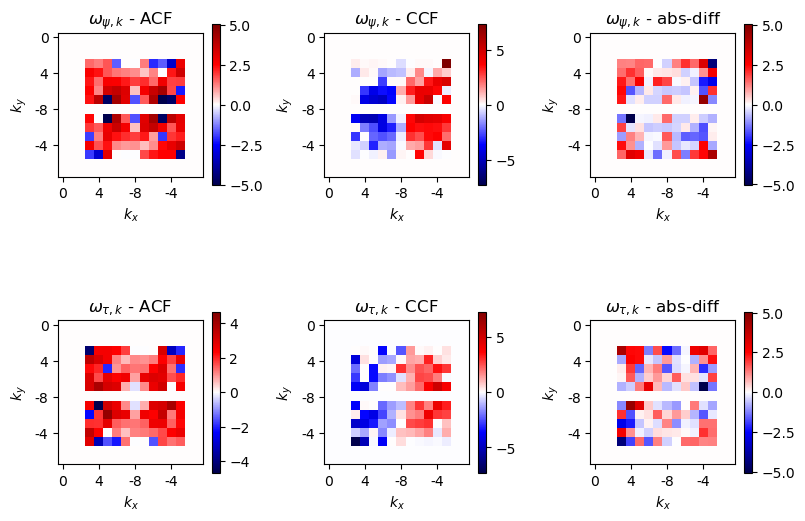

In [23]:
# Create a figure for the plots
params = np.load('../data/est_paras_ou_K16_beta22.npy', allow_pickle=True).item()
gamma, omega, f, sigma = params['gamma'], params['omega'], params['f'], params['sigma']

fig = plt.figure(figsize=(8, 6))

matrix1 = omega[:,:,0]
matrix2 = omega_est[:,:,0]
matrix1 = np.roll(matrix1, shift=K//2, axis=0)
matrix1 = np.roll(matrix1, shift=K//2, axis=1)
matrix2 = np.roll(matrix2, shift=K//2, axis=0) 
matrix2 = np.roll(matrix2, shift=K//2, axis=1)

# Plot for matrix1
ax1 = fig.add_subplot(231)  # 1 row, 2 columns, 1st subplot
surf1 = ax1.imshow(matrix1, cmap='seismic', vmin=-np.max(np.abs(matrix1)), vmax=np.max(np.abs(matrix1)))
ax1.set_title(r'$\omega_{\psi,k}$ - ACF')
ax1.set_xlabel('$k_x$')
ax1.set_ylabel('$k_y$')
# ax1.set_zlabel('Value')
ax1.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax1.set_xticklabels(kx[::K//4].astype(int))
ax1.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax1.set_yticklabels(kx[::K//4].astype(int))
fig.colorbar(surf1, shrink=0.6)#, ax=ax1, shrink=0.5, aspect=12)
lim1 = np.max(np.abs(matrix1))

# Plot for matrix2
ax2 = fig.add_subplot(232)  # 1 row, 2 columns, 2nd subplot
surf2 = ax2.imshow(matrix2, cmap='seismic', vmin=-np.max(np.abs(matrix2)), vmax=np.max(np.abs(matrix2)))
ax2.set_title(r'$\omega_{\psi,k}$ - CCF')
ax2.set_xlabel('$k_x$')
ax2.set_ylabel('$k_y$')
# ax2.set_zlabel('Value')
# ax2.set_zlim(-60, 60)
ax2.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax2.set_xticklabels(kx[::K//4].astype(int))
ax2.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax2.set_yticklabels(kx[::K//4].astype(int))
fig.colorbar(surf2, shrink=0.6)#, ax=ax2, shrink=0.5, aspect=12)

matrix1 = omega[:,:,1]
matrix2 = omega_est[:,:,1]
matrix1 = np.roll(matrix1, shift=K//2, axis=0)
matrix1 = np.roll(matrix1, shift=K//2, axis=1)
matrix2 = np.roll(matrix2, shift=K//2, axis=0) 
matrix2 = np.roll(matrix2, shift=K//2, axis=1)

# Plot for matrix1
ax3 = fig.add_subplot(234)  # 1 row, 2 columns, 1st subplot
surf1 = ax3.imshow(matrix1, cmap='seismic', vmin=-np.max(np.abs(matrix1)), vmax=np.max(np.abs(matrix1)))
ax3.set_title(r'$\omega_{\tau,k}$ - ACF')
ax3.set_xlabel('$k_x$')
ax3.set_ylabel('$k_y$')
# ax1.set_zlabel('Value')
ax3.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax3.set_xticklabels(kx[::K//4].astype(int))
ax3.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax3.set_yticklabels(kx[::K//4].astype(int))
fig.colorbar(surf1, shrink=0.6)#, ax=ax1, shrink=0.5, aspect=12)
lim1 = np.max(np.abs(matrix1)) / 100

# Plot for matrix2
ax4 = fig.add_subplot(235)  # 1 row, 2 columns, 2nd subplot
surf2 = ax4.imshow(matrix2, cmap='seismic', vmin=-np.max(np.abs(matrix2)), vmax=np.max(np.abs(matrix2)))
ax4.set_title(r'$\omega_{\tau,k}$ - CCF')
ax4.set_xlabel('$k_x$')
ax4.set_ylabel('$k_y$')
# ax2.set_zlabel('Value')
# ax2.set_zlim(-60, 60)
ax4.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax4.set_xticklabels(kx[::K//4].astype(int))
ax4.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax4.set_yticklabels(kx[::K//4].astype(int))
fig.colorbar(surf2, shrink=0.6)#, ax=ax2, shrink=0.5, aspect=12)

matrix1 = np.abs(omega[:,:,0])-np.abs(omega_est[:,:,0])
matrix2 = np.abs(omega[:,:,1])-np.abs(omega_est[:,:,1])
matrix1 = np.roll(matrix1, shift=K//2, axis=0)
matrix1 = np.roll(matrix1, shift=K//2, axis=1)
matrix2 = np.roll(matrix2, shift=K//2, axis=0) 
matrix2 = np.roll(matrix2, shift=K//2, axis=1)

# Plot for matrix1
ax5 = fig.add_subplot(233)  # 1 row, 2 columns, 1st subplot
surf1 = ax5.imshow(matrix1, cmap='seismic', vmin=-np.max(np.abs(matrix1)), vmax=np.max(np.abs(matrix1)))
ax5.set_title(r'$\omega_{\psi,k}$ - abs-diff')
ax5.set_xlabel('$k_x$')
ax5.set_ylabel('$k_y$')
# ax1.set_zlabel('Value')
ax5.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax5.set_xticklabels(kx[::K//4].astype(int))
ax5.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax5.set_yticklabels(kx[::K//4].astype(int))
fig.colorbar(surf1, shrink=0.6)#, ax=ax1, shrink=0.5, aspect=12)

# Plot for matrix2
ax6 = fig.add_subplot(236)  # 1 row, 2 columns, 2nd subplot
surf2 = ax6.imshow(matrix2, cmap='seismic', vmin=-np.max(np.abs(matrix2)), vmax=np.max(np.abs(matrix2)))
ax6.set_title(r'$\omega_{\tau,k}$ - abs-diff')
ax6.set_xlabel('$k_x$')
ax6.set_ylabel('$k_y$')
# ax2.set_zlabel('Value')
# ax2.set_zlim(-60, 60)
ax6.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax6.set_xticklabels(kx[::K//4].astype(int))
ax6.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax6.set_yticklabels(kx[::K//4].astype(int))
fig.colorbar(surf2, shrink=0.6)#, ax=ax2, shrink=0.5, aspect=12)

plt.tight_layout()
# plt.savefig('./LSM/omega_compare_K128.png',dpi=150)
plt.show()

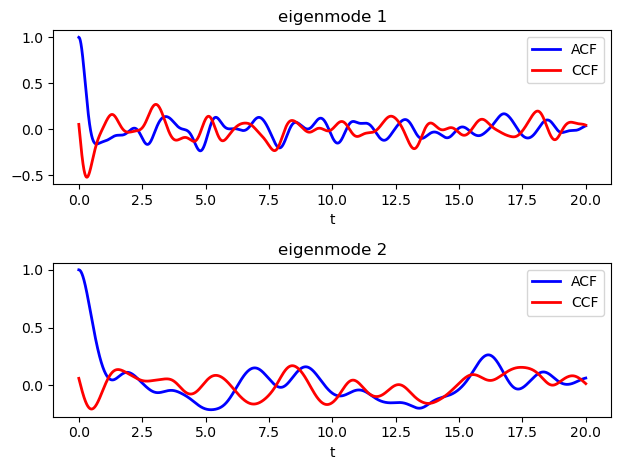

Estimated values:
gamma1, omega1, f1, sigma1
0.6929997764845156, -0.07733695637957008, (-1.9982810473415598+0.5237272340652473j), 22.61225317995604
gamma2, omega2, f2, sigma2
1.3645662641077496, 3.469503750529897, (0.4732955442852069+1.2425861900452086j), 12.331381389649446


In [12]:
# Showing the ACF and the cross-correlation
plt.subplot(2, 1, 1)
plt.plot(tt, acf_psi1, 'b', linewidth=2, label='ACF')
plt.plot(tt, ccf_psi1, 'r', linewidth=2, label='CCF')
plt.title('eigenmode 1')
plt.legend()
plt.xlabel('t')

plt.subplot(2, 1, 2)
plt.plot(tt, acf_psi2, 'b', linewidth=2, label='ACF')
plt.plot(tt, ccf_psi2, 'r', linewidth=2, label='CCF')
plt.title('eigenmode 2')
plt.legend()
plt.xlabel('t')
plt.tight_layout()
plt.show()

print('Estimated values:')
print(f'gamma1, omega1, f1, sigma1')
print(f'{gamma1_est}, {omega1_est}, {f1_est}, {sigma1_est}')
print(f'gamma2, omega2, f2, sigma2')
print(f'{gamma2_est}, {omega2_est}, {f2_est}, {sigma2_est}')

In [8]:
# save fitted parameters
est_params = {
    'gamma': gamma_est,
    'omega': omega_est,
    'f': f_est,
    'sigma': sigma_est,
    'cut': cut
}
np.save('../data/est_paras_ou_K16_beta22.npy', est_params)

In [9]:
np.where(gamma_est < 0)[0].shape

(0,)

### check acf

In [4]:
def find_indices(kx, ky):
    square = []
    for ik, kx_value in enumerate(kx):
        square.append(kx_value**2)
    # List to store the pairs of indices
    indices_x = []
    indices_y = []

    # Iterate through each element in kx
    for i in range(len(kx)):
        # Iterate through each element in ky
        for j in range(len(ky)):
            # Check if the condition kx[i]^2 + ky[j]^2 = 100 is met
            if kx[i]**2 + ky[j]**2 in square and kx[i] > 0 and ky[j] > 0:
                print((kx[i]**2 + ky[j]**2)**0.5)
                # If condition is met, add the pair of indices (i, j) to the list
                indices_x.append(i)
                indices_y.append(j)

    return indices_x,indices_y

K=128
kx = np.fft.fftfreq(K) * K
ky = np.fft.fftfreq(K) * K
ix, iy = find_indices(kx,ky)

5.0
5.0
13.0
10.0
25.0
10.0
17.0
15.0
41.0
26.0
61.0
13.0
15.0
20.0
37.0
50.0
17.0
25.0
39.0
20.0
34.0
30.0
25.0
29.0
52.0
29.0
35.0
25.0
26.0
30.0
40.0
51.0
45.0
35.0
53.0
34.0
50.0
40.0
55.0
37.0
39.0
45.0
60.0
41.0
50.0
58.0
58.0
55.0
51.0
53.0
50.0
52.0
60.0
61.0


In [27]:
print(ix)
print(iy)

[3, 4, 5, 6, 7, 8, 8, 9, 9, 10, 11, 12, 12, 12, 12, 14, 15, 15, 15, 16, 16, 18, 20, 20, 20, 21, 21, 24, 24, 24, 24, 24, 27, 28, 28, 30, 30, 32, 33, 35, 36, 36, 36, 40, 40, 40, 42, 44, 45, 45, 48, 48, 48, 60]
[4, 3, 12, 8, 24, 6, 15, 12, 40, 24, 60, 5, 9, 16, 35, 48, 8, 20, 36, 12, 30, 24, 15, 21, 48, 20, 28, 7, 10, 18, 32, 45, 36, 21, 45, 16, 40, 24, 44, 12, 15, 27, 48, 9, 30, 42, 40, 33, 24, 28, 14, 20, 36, 11]


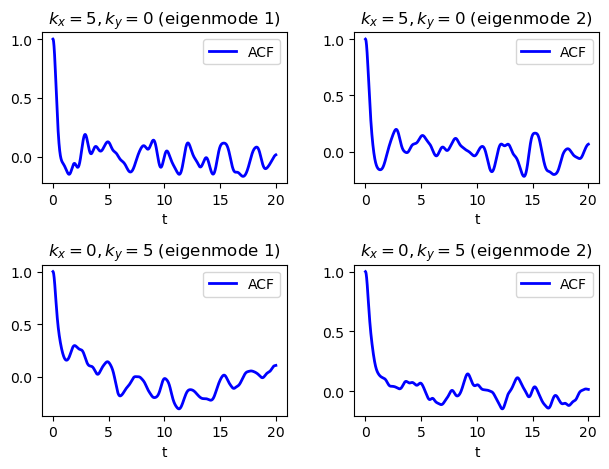

In [25]:
# beta=22
def acf_eigen(psi1_hat_t, psi2_hat_t, r1, r2, ikx, iky, Lag):
    eigenmat_inv = np.linalg.inv(np.array([r1[iky,ikx,:],r2[iky,ikx,:]]).T)
    eigenmode = eigenmat_inv @ np.array([psi1_hat_t[iky,ikx,:],psi2_hat_t[iky,ikx,:]])
    psi1_hat = eigenmode[0,:] 
    psi2_hat = eigenmode[1,:]
    acf_psi1 = acf(np.real(psi1_hat), nlags=Lag, fft=True)  # ACF of the real part
    acf_psi2 = acf(np.real(psi2_hat), nlags=Lag, fft=True)  # ACF of the real part
#     acf_psi1 = acf(np.real(psi1_hat_t[iky,ikx,:]), nlags=Lag, fft=True)  # ACF of the real part
#     acf_psi2 = acf(np.real(psi2_hat_t[iky,ikx,:]), nlags=Lag, fft=True)  # ACF of the real part
    
    return acf_psi1, acf_psi2

Lag = 40000  # lag for computing the ACF
tt = np.linspace(0, Lag*dt, num=Lag+1, endpoint=True) # time interval to plot the ACF or cross-correlation function

ikx = 5; iky = 0;
acf_psi1, acf_psi2 = acf_eigen(psi1_hat_t, psi2_hat_t, r1, r2, ikx, iky, Lag)
# Showing the ACF and the cross-correlation
plt.subplot(2, 2, 1)
plt.plot(tt, acf_psi1, 'b', linewidth=2, label='ACF')
# plt.plot(tt, ccf_psi1, 'r', linewidth=2, label='Cross-correlation function')
plt.title(r'$k_x={0}, k_y={1}$ (eigenmode 1)'.format(ikx,iky))
plt.legend()
plt.xlabel('t')

plt.subplot(2, 2, 2)
plt.plot(tt, acf_psi2, 'b', linewidth=2, label='ACF')
# plt.plot(tt, ccf_psi2, 'r', linewidth=2, label='Cross-correlation function')
plt.title(r'$k_x={0}, k_y={1}$ (eigenmode 2)'.format(ikx,iky))
plt.legend()
plt.xlabel('t')

ikx = 0; iky = 5;
acf_psi1, acf_psi2 = acf_eigen(psi1_hat_t, psi2_hat_t, r1, r2, ikx, iky, Lag)
plt.subplot(2, 2, 3)
plt.plot(tt, acf_psi1, 'b', linewidth=2, label='ACF')
# plt.plot(tt, ccf_psi1, 'r', linewidth=2, label='Cross-correlation function')
plt.title(r'$k_x={0}, k_y={1}$ (eigenmode 1)'.format(ikx,iky))
plt.legend()
plt.xlabel('t')

plt.subplot(2, 2, 4)
plt.plot(tt, acf_psi2, 'b', linewidth=2, label='ACF')
# plt.plot(tt, ccf_psi2, 'r', linewidth=2, label='Cross-correlation function')
plt.title(r'$k_x={0}, k_y={1}$ (eigenmode 2)'.format(ikx,iky))
plt.legend()
plt.xlabel('t')
plt.tight_layout()

plt.show()

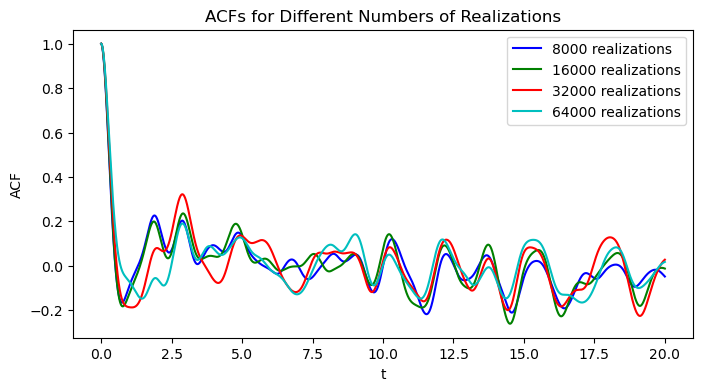

In [29]:
# varies the number of realizations used to estimate ACF    
def acf_eigen(psi1_hat_t, psi2_hat_t, r1, r2, ikx, iky, Lag):
    eigenmat_inv = np.linalg.inv(np.array([r1[iky,ikx,:],r2[iky,ikx,:]]).T)
    eigenmode = eigenmat_inv @ np.array([psi1_hat_t[iky,ikx,:],psi2_hat_t[iky,ikx,:]])
    psi1_hat = eigenmode[0,:] 
    psi2_hat = eigenmode[1,:]
    acf_psi1 = acf(np.real(psi1_hat), nlags=Lag, fft=True)  # ACF of the real part
    acf_psi2 = acf(np.real(psi2_hat), nlags=Lag, fft=True)  # ACF of the real part
#     acf_psi1 = acf(np.real(psi1_hat_t[iky,ikx,:]), nlags=Lag, fft=True)  # ACF of the real part
#     acf_psi2 = acf(np.real(psi2_hat_t[iky,ikx,:]), nlags=Lag, fft=True)  # ACF of the real part
    return acf_psi1, acf_psi2

nums = [8000, 16000, 32000, 64000]
Lag = 40000  # lag for computing the ACF
tt = np.linspace(0, Lag*dt, num=Lag+1, endpoint=True) # time interval to plot the ACF or cross-correlation function
acf_psi = np.zeros((Lag+1,len(nums)))
acf_tau = np.zeros((Lag+1,len(nums)))

ikx = 5; iky = 0;
for inum,num in enumerate(nums):
    acf_psi[:,inum], acf_tau[:,inum] = acf_eigen(psi1_hat_t[:,:,:num+Lag], psi2_hat_t[:,:,:num+Lag], r1, r2, ikx, iky, Lag)
    
plt.figure(figsize=(8, 4))  # Set the figure size (optional)

colors = ['b', 'g', 'r', 'c','k']  # Colors for different lines
labels = [f'{num} realizations' for num in nums]  # Labels for the legend

for i in range(len(nums)):
    plt.plot(tt, acf_psi[:, i], color=colors[i], label=labels[i])

plt.xlabel('t')
plt.ylabel('ACF')
plt.title('ACFs for Different Numbers of Realizations')
plt.legend()
plt.show()

### check the estimation of sigma |k|^2=100

In [72]:
# check 
Lag = 5000  # lag for computing the ACF
tt = np.linspace(0, Lag*dt, num=Lag+1, endpoint=True) # time interval to plot the ACF or cross-correlation function
gamma_est = np.zeros((K,K,2))
omega_est = np.zeros((K,K,2))
f_est = np.zeros((K,K,2), dtype='complex')
sigma_est = np.zeros((K,K,2))
kx = np.fft.fftfreq(K) * K
ky = np.fft.fftfreq(K) * K
cut = 16

for ikx,kx_value in enumerate(kx):
    for iky,ky_value in enumerate(ky): 
        if (kx_value**2 + ky_value**2) == 100:
            eigenmat_inv = np.linalg.inv(np.array([r1[iky,ikx,:],r2[iky,ikx,:]]).T)
            eigenmode = eigenmat_inv @ np.array([psi1_hat_t[iky,ikx,:],psi2_hat_t[iky,ikx,:]])
            psi1_hat = eigenmode[0,:] 
            psi2_hat = eigenmode[1,:]
            acf_psi1 = acf(np.real(psi1_hat), nlags=Lag, fft=True)  # ACF of the real part
            acf_psi2 = acf(np.real(psi2_hat), nlags=Lag, fft=True)  # ACF of the real part
#             ccf_psi1 = -ccf(np.real(psi1_hat), np.imag(psi1_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts 
#             ccf_psi2 = -ccf(np.real(psi2_hat), np.imag(psi2_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts

            # Fitting the cross-correlation function
            x0 = [0.5, 0.5]
            x1, _ = curve_fit(ACF, tt, acf_psi1, p0=x0, check_finite=True, maxfev=2000)
            # Estimated values
            gamma1_est = x1[0]
            omega1_est = x1[1]
            m1 = np.mean(psi1_hat)
            E1 = np.var(psi1_hat)
            T1 = gamma1_est / (gamma1_est**2 + omega1_est**2)
            theta1 = omega1_est / (gamma1_est**2 + omega1_est**2)
            f1_est = m1 * (T1 - 1j*theta1) / (T1**2 + theta1**2)
            sigma1_est = np.sqrt(2*E1*T1 / (T1**2 + theta1**2))
            gamma_est[iky,ikx,0] = gamma1_est; omega_est[iky,ikx,0] = omega1_est; f_est[iky,ikx,0] = f1_est; sigma_est[iky,ikx,0] = sigma1_est;

            x2, _ = curve_fit(ACF, tt, acf_psi2, p0=x0, check_finite=True, maxfev=2000)
            # Estimated values
            gamma2_est = x2[0]
            omega2_est = x2[1]
            m2 = np.mean(psi2_hat)
            E2 = np.var(psi2_hat)
            T2 = gamma2_est / (gamma2_est**2 + omega2_est**2)
            theta2 = omega2_est / (gamma2_est**2 + omega2_est**2)
            f2_est = m2 * (T2 - 1j*theta2) / (T2**2 + theta2**2)
            sigma2_est = np.sqrt(2*E2*T2 / (T2**2 + theta2**2))
            gamma_est[iky,ikx,1] = gamma2_est; omega_est[iky,ikx,1] = omega2_est; f_est[iky,ikx,1] = f2_est; sigma_est[iky,ikx,1] = sigma2_est;


In [83]:
print(E1,T1, theta1)
print(E2,T2, theta2)

6950475.209216574 0.07629049837199353 0.06441019543200628
7040368.851758603 0.07787232462225879 0.0614408814406368


In [93]:
eigmode = np.linalg.inv(np.array([r1[0,10,:],r2[0,10,:]]).T) @ np.array([psi1_hat_t[0,10,:],psi2_hat_t[0,10,:]])

In [96]:
np.var(eigmode[0,:])

7750662.221809279

In [87]:
print(kx[ix])
print(ky[iy])

[  0.   0.   6.   6.   8.   8.  10. -10.  -8.  -8.  -6.  -6.]
[ 10. -10.   8.  -8.   6.  -6.   0.   0.   6.  -6.   8.  -8.]


In [74]:
def find_indices(kx, ky):
    # List to store the pairs of indices
    indices_x = []
    indices_y = []

    # Iterate through each element in kx
    for i in range(len(kx)):
        # Iterate through each element in ky
        for j in range(len(ky)):
            # Check if the condition kx[i]^2 + ky[j]^2 = 100 is met
            if kx[i]**2 + ky[j]**2 == 100:
                # If condition is met, add the pair of indices (i, j) to the list
                indices_x.append(i)
                indices_y.append(j)

    return indices_x,indices_y

ix, iy = find_indices(kx,ky)
sigma_est[ix,iy,:]

array([[11728.19525376, 11648.48968025],
       [11728.19525376, 11648.48968025],
       [13812.55411613, 13888.05639449],
       [ 6632.86429584,  6347.8308942 ],
       [10314.15280485, 10556.67154035],
       [13441.70827609, 13497.58752917],
       [13732.11587021, 11965.69647127],
       [13732.11588902, 11965.69647739],
       [13441.70827592, 13497.58752826],
       [10314.15280214, 10556.67154106],
       [ 6632.86429507,  6347.83089356],
       [13812.55414828, 13888.05639443]])

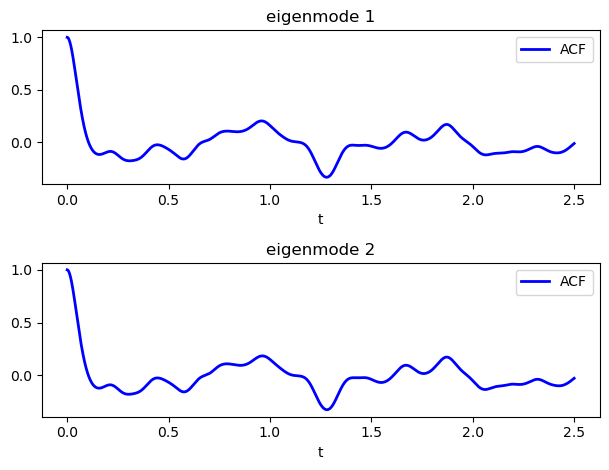

In [118]:
# plot acf
def acf_eigen(psi1_hat_t, psi2_hat_t, r1, r2, ikx, iky):
    eigenmat_inv = np.linalg.inv(np.array([r1[iky,ikx,:],r2[iky,ikx,:]]).T)
    eigenmode = eigenmat_inv @ np.array([psi1_hat_t[iky,ikx,:],psi2_hat_t[iky,ikx,:]])
    psi1_hat = eigenmode[0,:] 
    psi2_hat = eigenmode[1,:]
    acf_psi1 = acf(np.real(psi1_hat), nlags=Lag, fft=True)  # ACF of the real part
    acf_psi2 = acf(np.real(psi2_hat), nlags=Lag, fft=True)  # ACF of the real part
    
    return acf_psi1, acf_psi2

acf_psi1, acf_psi2 = acf_eigen(psi1_hat_t, psi2_hat_t, r1, r2, 10, 0)
# Showing the ACF and the cross-correlation
plt.subplot(2, 1, 1)
plt.plot(tt, acf_psi1, 'b', linewidth=2, label='ACF')
# plt.plot(tt, ccf_psi1, 'r', linewidth=2, label='Cross-correlation function')
plt.title('eigenmode 1')
plt.legend()
plt.xlabel('t')

plt.subplot(2, 1, 2)
plt.plot(tt, acf_psi2, 'b', linewidth=2, label='ACF')
# plt.plot(tt, ccf_psi2, 'r', linewidth=2, label='Cross-correlation function')
plt.title('eigenmode 2')
plt.legend()
plt.xlabel('t')
plt.tight_layout()
plt.show()

### calibration using ccf

In [43]:
#The ansatz of the cross-correlation
def CCF(data, gamma, omega):
    return np.exp(-gamma*data) * np.sin(omega*data)

def ACF(data, gamma, omega):
    return np.exp(-gamma*data) * np.cos(omega*data)


Lag = 4000  # lag for computing the ACF
tt = np.linspace(0, Lag*dt, num=Lag+1, endpoint=True) # time interval to plot the ACF or cross-correlation function
gamma_est = np.zeros((K,K,2))
omega_est = np.zeros((K,K,2))
f_est = np.zeros((K,K,2), dtype='complex')
sigma_est = np.zeros((K,K,2))
kx = np.fft.fftfreq(K) * K
ky = np.fft.fftfreq(K) * K
cut = 16

for ikx,kx_value in enumerate(kx):
    for iky,ky_value in enumerate(ky): 
        if (ky_value == 0 and ky_value==0) or abs(kx_value) >= (K//2-cut) or abs(ky_value) >= (K//2-cut):  # Skip the case where k_mag is 0 and truncation
            continue
        
#         print(kx_value, ky_value)

#         psi1_hat = (psi1_hat_t[ikx,iky,:] + psi2_hat_t[ikx,iky,:]) / 2 # This is a mistake. I should get the two eigenmode using r1 and r2
#         psi2_hat = (psi1_hat_t[ikx,iky,:] - psi2_hat_t[ikx,iky,:]) / 2
        eigenmat_inv = np.linalg.inv(np.array([r1[iky,ikx,:],r2[iky,ikx,:]]).T)
        eigenmode = eigenmat_inv @ np.array([psi1_hat_t[iky,ikx,:],psi2_hat_t[iky,ikx,:]])
        psi1_hat = eigenmode[0,:] 
        psi2_hat = eigenmode[1,:]
        acf_psi1 = acf(np.real(psi1_hat), nlags=Lag, fft=True)  # ACF of the real part
        acf_psi2 = acf(np.real(psi2_hat), nlags=Lag, fft=True)  # ACF of the real part
        ccf_psi1 = -ccf(np.real(psi1_hat), np.imag(psi1_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts 
        ccf_psi2 = -ccf(np.real(psi2_hat), np.imag(psi2_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts

        # Fitting the cross-correlation function
        x0 = [0.5, 0.5]
        x1, _ = curve_fit(CCF, tt, acf_psi1, p0=x0, check_finite=True, maxfev=8000)
        # Estimated values
        gamma1_est = x1[0]
        omega1_est = x1[1]
        m1 = np.mean(psi1_hat)
        E1 = np.var(psi1_hat)
        T1 = gamma1_est / (gamma1_est**2 + omega1_est**2)
        theta1 = omega1_est / (gamma1_est**2 + omega1_est**2)
        f1_est = m1 * (T1 - 1j*theta1) / (T1**2 + theta1**2)
        sigma1_est = np.sqrt(2*E1*T1 / (T1**2 + theta1**2))
        gamma_est[iky,ikx,0] = gamma1_est; omega_est[iky,ikx,0] = omega1_est; f_est[iky,ikx,0] = f1_est; sigma_est[iky,ikx,0] = sigma1_est;
        
        x2, _ = curve_fit(CCF, tt, acf_psi2, p0=x0, check_finite=True, maxfev=8000)
        # Estimated values
        gamma2_est = x2[0]
        omega2_est = x2[1]
        m2 = np.mean(psi2_hat)
        E2 = np.var(psi2_hat)
        T2 = gamma2_est / (gamma2_est**2 + omega2_est**2)
        theta2 = omega2_est / (gamma2_est**2 + omega2_est**2)
        f2_est = m2 * (T2 - 1j*theta2) / (T2**2 + theta2**2)
        sigma2_est = np.sqrt(2*E2*T2 / (T2**2 + theta2**2))
        gamma_est[iky,ikx,1] = gamma2_est; omega_est[iky,ikx,1] = omega2_est; f_est[iky,ikx,1] = f2_est; sigma_est[iky,ikx,1] = sigma2_est;


/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_70929/509964511.py:60: RuntimeWarning: invalid value encountered in sqrt
  sigma2_est = np.sqrt(2*E2*T2 / (T2**2 + theta2**2))
/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_70929/509964511.py:48: RuntimeWarning: invalid value encountered in sqrt
  sigma1_est = np.sqrt(2*E1*T1 / (T1**2 + theta1**2))


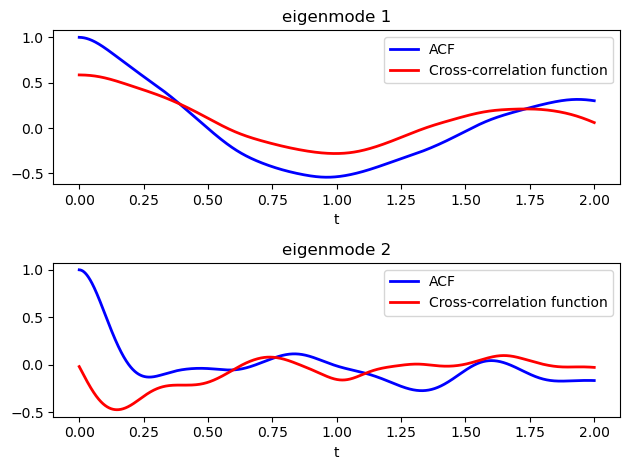

Estimated values:
gamma1, omega1, f1, sigma1
1.0686002298588626, -0.36928478398628956, (-450.89509239826964-206.66123959801462j), 900.9406658104314
gamma2, omega2, f2, sigma2
6.301719000381832, 17.791206004678116, (284.1386405045165-6216.175245233863j), 5690.7861477075885


In [44]:
# Showing the ACF and the cross-correlation
plt.subplot(2, 1, 1)
plt.plot(tt, acf_psi1, 'b', linewidth=2, label='ACF')
plt.plot(tt, ccf_psi1, 'r', linewidth=2, label='Cross-correlation function')
plt.title('eigenmode 1')
plt.legend()
plt.xlabel('t')

plt.subplot(2, 1, 2)
plt.plot(tt, acf_psi2, 'b', linewidth=2, label='ACF')
plt.plot(tt, ccf_psi2, 'r', linewidth=2, label='Cross-correlation function')
plt.title('eigenmode 2')
plt.legend()
plt.xlabel('t')
plt.tight_layout()
plt.show()

print('Estimated values:')
print(f'gamma1, omega1, f1, sigma1')
print(f'{gamma1_est}, {omega1_est}, {f1_est}, {sigma1_est}')
print(f'gamma2, omega2, f2, sigma2')
print(f'{gamma2_est}, {omega2_est}, {f2_est}, {sigma2_est}')

In [45]:
np.where(gamma_est < 0)[0].shape

(2702,)

## Compare the eigenvalue to data-driven $\omega_{\mathbf{k}}$

In [39]:
# load parameters
params = np.load('../data/est_paras_ou_K128_beta22.npy', allow_pickle=True).item()
gamma, omega, f, sigma = params['gamma'], params['omega'], params['f'], params['sigma']
eigens = np.load('../data/eigens_K128_beta22.npy', allow_pickle=True)
omega1 = eigens.item()['omega1']
omega2 = eigens.item()['omega2']

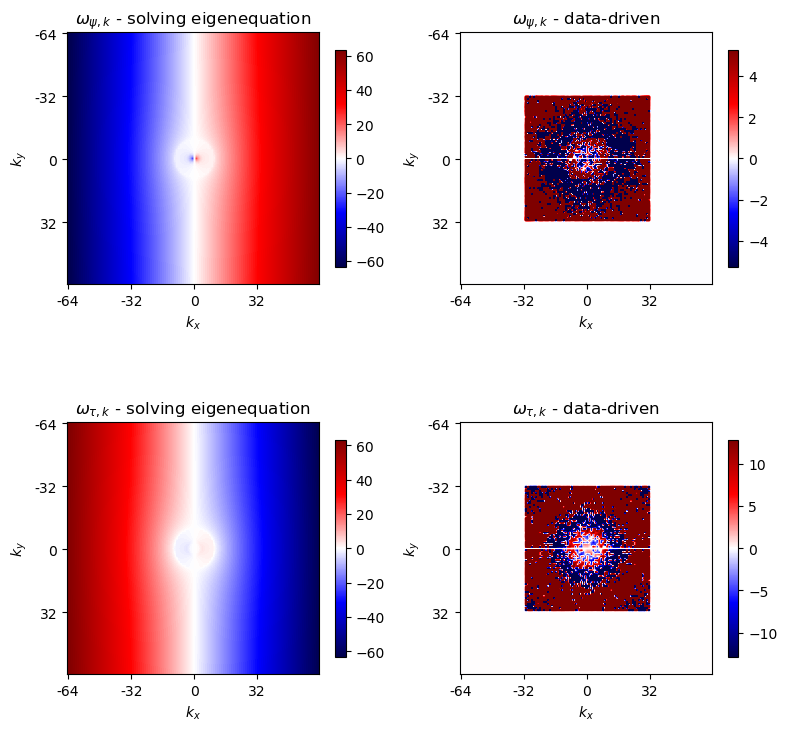

In [41]:
# plot omega
from scipy.ndimage import gaussian_filter

%matplotlib inline

matrix1 = omega1.real
matrix2 = omega[:,:,0]
matrix1 = np.roll(matrix1, shift=K//2, axis=0)
matrix1 = np.roll(matrix1, shift=K//2, axis=1)
matrix2 = np.roll(matrix2, shift=K//2, axis=0) 
matrix2 = np.roll(matrix2, shift=K//2, axis=1)

matrix3 = omega2.real
matrix4 = omega[:,:,1]
matrix3 = np.roll(matrix3, shift=K//2, axis=0)
matrix3 = np.roll(matrix3, shift=K//2, axis=1)
matrix4 = np.roll(matrix4, shift=K//2, axis=0) 
matrix4 = np.roll(matrix4, shift=K//2, axis=1)

# Generate grid indices for the KxK matrices
x = np.linspace(0, K, num=K, endpoint=False) #np.fft.fftfreq(K) * K
y = np.linspace(0, K, num=K, endpoint=False) #np.fft.fftfreq(K) * K
X, Y = np.meshgrid(x, y)
kx = np.roll(np.fft.fftfreq(K) * K, shift=K//2)
ky = np.roll(np.fft.fftfreq(K) * K, shift=K//2)
smoothed_matrix2 = gaussian_filter(matrix2, sigma=.1)
smoothed_matrix4 = gaussian_filter(matrix4, sigma=.1)

# Create a figure for the plots
fig = plt.figure(figsize=(8, 8))

# Plot for matrix1
ax1 = fig.add_subplot(221)  # 1 row, 2 columns, 1st subplot
surf1 = ax1.imshow(matrix1, cmap='seismic', vmin=-np.max(np.abs(matrix1)), vmax=np.max(np.abs(matrix1)))
ax1.set_title(r'$\omega_{\psi,k}$ - solving eigenequation')
ax1.set_xlabel('$k_x$')
ax1.set_ylabel('$k_y$')
# ax1.set_zlabel('Value')
ax1.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax1.set_xticklabels(kx[::32].astype(int))
ax1.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax1.set_yticklabels(kx[::32].astype(int))
fig.colorbar(surf1, shrink=0.6)#, ax=ax1, shrink=0.5, aspect=12)

# Plot for matrix2
ax2 = fig.add_subplot(222)  # 1 row, 2 columns, 2nd subplot
surf2 = ax2.imshow(smoothed_matrix2, cmap='seismic', vmin=-np.max(np.abs(smoothed_matrix2))/5, vmax=np.max(np.abs(smoothed_matrix2))/5)
ax2.set_title(r'$\omega_{\psi,k}$ - data-driven')
ax2.set_xlabel('$k_x$')
ax2.set_ylabel('$k_y$')
# ax2.set_zlabel('Value')
# ax2.set_zlim(-60, 60)
ax2.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax2.set_xticklabels(kx[::32].astype(int))
ax2.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax2.set_yticklabels(kx[::32].astype(int))
fig.colorbar(surf2, shrink=0.6)#, ax=ax2, shrink=0.5, aspect=12)

# Plot for matrix1
ax3 = fig.add_subplot(223)  # 1 row, 2 columns, 1st subplot
surf3 = ax3.imshow(matrix3, cmap='seismic', vmin=-np.max(np.abs(matrix3)), vmax=np.max(np.abs(matrix3)))
ax3.set_title(r'$\omega_{\tau,k}$ - solving eigenequation')
ax3.set_xlabel('$k_x$')
ax3.set_ylabel('$k_y$')
# ax3.set_zlabel('Value')
ax3.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax3.set_xticklabels(kx[::32].astype(int))
ax3.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax3.set_yticklabels(kx[::32].astype(int))
fig.colorbar(surf3, shrink=0.6)#, ax=ax3, shrink=0.5, aspect=12)

# Plot for matrix2
ax4 = fig.add_subplot(224)  # 1 row, 2 columns, 2nd subplot
surf4 = ax4.imshow(smoothed_matrix4, cmap='seismic', vmin=-np.max(np.abs(smoothed_matrix4))/5, vmax=np.max(np.abs(smoothed_matrix4))/5)
ax4.set_title(r'$\omega_{\tau,k}$ - data-driven')
ax4.set_xlabel('$k_x$')
ax4.set_ylabel('$k_y$')
# ax4.set_zlabel('Value')
# ax4.set_zlim(-np.max(np.abs(smoothed_matrix4)), -np.max(np.abs(smoothed_matrix4)))
ax4.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax4.set_xticklabels(kx[::32].astype(int))
ax4.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax4.set_yticklabels(kx[::32].astype(int))
fig.colorbar(surf4, shrink=0.6)#, ax=ax4, shrink=0.5, aspect=12)

plt.tight_layout()
# plt.savefig('./LSM/omega_compare_K128.png',dpi=150)
plt.show()

In [30]:
# load parameters
params = np.load('../data/est_paras_ou_K128_beta22.npy', allow_pickle=True).item()
gamma, omega, f, sigma = params['gamma'], params['omega'], params['f'], params['sigma']
eigens = np.load('../data/eigens_K128_beta22.npy', allow_pickle=True)
omega1 = eigens.item()['omega1']
omega2 = eigens.item()['omega2']
# plot omega
from scipy.ndimage import gaussian_filter

%matplotlib inline
#The ansatz of the cross-correlation
def CCF(data, gamma, omega):
    return np.exp(-gamma*data) * np.sin(omega*data)

def ACF(data, gamma, omega):
    return np.exp(-gamma*data) * np.cos(omega*data)


Lag = 10000  # lag for computing the ACF
tt = np.linspace(0, Lag*dt, num=Lag+1, endpoint=True) # time interval to plot the ACF or cross-correlation function
gamma_est = np.zeros((K,K,2))
omega_est = np.zeros((K,K,2))
f_est = np.zeros((K,K,2), dtype='complex')
sigma_est = np.zeros((K,K,2))
kx = np.fft.fftfreq(K) * K
ky = np.fft.fftfreq(K) * K
cut = 32

# omega[0,:,0]
iky=0; ikx=5
eigenmat_inv = np.linalg.inv(np.array([r1[iky,ikx,:],r2[iky,ikx,:]]).T)
eigenmode = eigenmat_inv @ np.array([psi1_hat_t[iky,ikx,:],psi2_hat_t[iky,ikx,:]])
psi1_hat = eigenmode[0,:] 
psi2_hat = eigenmode[1,:]
acf_psi1 = acf(np.real(psi1_hat), nlags=Lag, fft=True)  # ACF of the real part
acf_psi2 = acf(np.real(psi2_hat), nlags=Lag, fft=True)  # ACF of the real part
ccf_psi1 = -ccf(np.real(psi1_hat), np.imag(psi1_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts 
ccf_psi2 = -ccf(np.real(psi2_hat), np.imag(psi2_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts

# Fitting the cross-correlation function
x0 = [0.5, 0.5]
x1, _ = curve_fit(ACF, tt, acf_psi1, p0=x0, check_finite=True, maxfev=2000)
# Estimated values
gamma1_est = x1[0]
omega1_est = x1[1]
m1 = np.mean(psi1_hat)
E1 = np.var(psi1_hat)
T1 = gamma1_est / (gamma1_est**2 + omega1_est**2)
theta1 = omega1_est / (gamma1_est**2 + omega1_est**2)
f1_est = m1 * (T1 - 1j*theta1) / (T1**2 + theta1**2)
sigma1_est = np.sqrt(2*E1*T1 / (T1**2 + theta1**2))

x2, _ = curve_fit(ACF, tt, acf_psi2, p0=x0, check_finite=True, maxfev=2000)
# Estimated values
gamma2_est = x2[0]
omega2_est = x2[1]
m2 = np.mean(psi2_hat)
E2 = np.var(psi2_hat)
T2 = gamma2_est / (gamma2_est**2 + omega2_est**2)
theta2 = omega2_est / (gamma2_est**2 + omega2_est**2)
f2_est = m2 * (T2 - 1j*theta2) / (T2**2 + theta2**2)
sigma2_est = np.sqrt(2*E2*T2 / (T2**2 + theta2**2))

In [32]:
omega1_est

3.2943461295474656

In [33]:
omega2_est

4.207892606323265

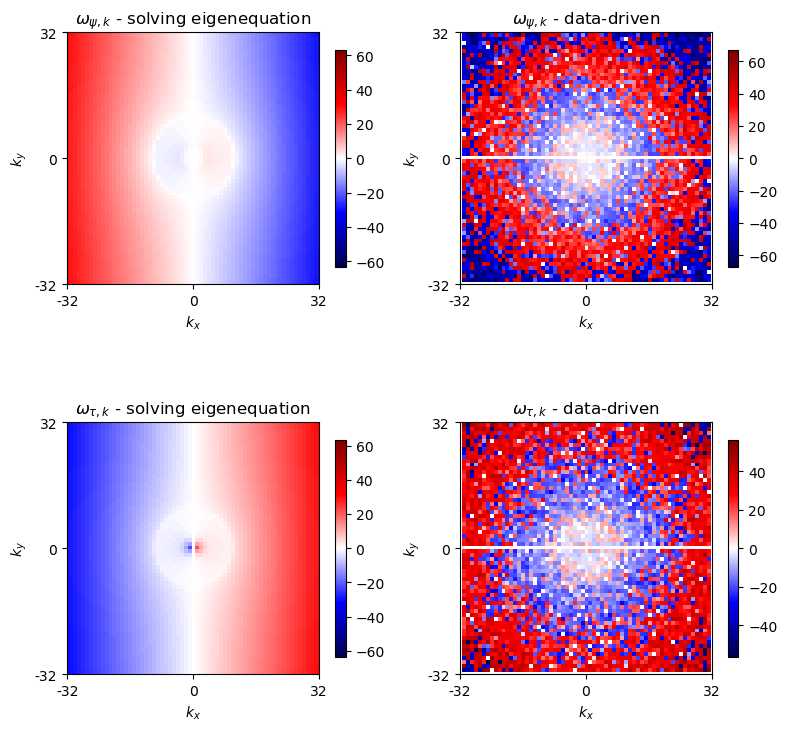

In [19]:
# beta=22
# load parameters
params = np.load('../data/est_paras_ou_K128_beta22.npy', allow_pickle=True).item()
gamma, omega, f, sigma = params['gamma'], params['omega'], params['f'], params['sigma']
eigens = np.load('../data/eigens_K128_beta22.npy', allow_pickle=True)
omega1 = eigens.item()['omega1']
omega2 = eigens.item()['omega2']
# plot omega
from scipy.ndimage import gaussian_filter

%matplotlib inline

matrix1 = omega1.real
matrix2 = omega[:,:,0]
matrix1 = np.roll(matrix1, shift=K//2, axis=0)
matrix1 = np.roll(matrix1, shift=K//2, axis=1)
matrix2 = np.roll(matrix2, shift=K//2, axis=0) 
matrix2 = np.roll(matrix2, shift=K//2, axis=1)

matrix3 = omega2.real
matrix4 = omega[:,:,1]
matrix3 = np.roll(matrix3, shift=K//2, axis=0)
matrix3 = np.roll(matrix3, shift=K//2, axis=1)
matrix4 = np.roll(matrix4, shift=K//2, axis=0) 
matrix4 = np.roll(matrix4, shift=K//2, axis=1)

# Generate grid indices for the KxK matrices
x = np.linspace(0, K, num=K, endpoint=False) #np.fft.fftfreq(K) * K
y = np.linspace(0, K, num=K, endpoint=False) #np.fft.fftfreq(K) * K
X, Y = np.meshgrid(x, y)
kx = np.roll(np.fft.fftfreq(K) * K, shift=K//2)
ky = np.roll(np.fft.fftfreq(K) * K, shift=K//2)
smoothed_matrix2 = gaussian_filter(matrix2, sigma=.1)
smoothed_matrix4 = gaussian_filter(matrix4, sigma=.1)

# Create a figure for the plots
fig = plt.figure(figsize=(8, 8))

# Plot for matrix1
ax1 = fig.add_subplot(221)  # 1 row, 2 columns, 1st subplot
surf1 = ax1.imshow(matrix1, cmap='seismic', vmin=-np.max(np.abs(matrix1)), vmax=np.max(np.abs(matrix1)))
ax1.set_title(r'$\omega_{\psi,k}$ - solving eigenequation')
ax1.set_xlabel('$k_x$')
ax1.set_ylabel('$k_y$')
# ax1.set_zlabel('Value')
ax1.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax1.set_xticklabels(kx[::32].astype(int))
ax1.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax1.set_yticklabels(kx[::32].astype(int))
ax1.set_xlim(32, 96)
ax1.set_ylim(32, 96)
fig.colorbar(surf1, shrink=0.6)#, ax=ax1, shrink=0.5, aspect=12)

# Plot for matrix2
ax2 = fig.add_subplot(222)  # 1 row, 2 columns, 2nd subplot
surf2 = ax2.imshow(smoothed_matrix2, cmap='seismic', vmin=-np.max(np.abs(smoothed_matrix2)), vmax=np.max(np.abs(smoothed_matrix2)))
ax2.set_title(r'$\omega_{\psi,k}$ - data-driven')
ax2.set_xlabel('$k_x$')
ax2.set_ylabel('$k_y$')
# ax2.set_zlabel('Value')
# ax2.set_zlim(-60, 60)
ax2.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax2.set_xticklabels(kx[::32].astype(int))
ax2.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax2.set_yticklabels(kx[::32].astype(int))
ax2.set_xlim(32, 96)
ax2.set_ylim(32, 96)
fig.colorbar(surf2, shrink=0.6)#, ax=ax2, shrink=0.5, aspect=12)

# Plot for matrix1
ax3 = fig.add_subplot(223)  # 1 row, 2 columns, 1st subplot
surf3 = ax3.imshow(matrix3, cmap='seismic', vmin=-np.max(np.abs(matrix3)), vmax=np.max(np.abs(matrix3)))
ax3.set_title(r'$\omega_{\tau,k}$ - solving eigenequation')
ax3.set_xlabel('$k_x$')
ax3.set_ylabel('$k_y$')
# ax3.set_zlabel('Value')
ax3.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax3.set_xticklabels(kx[::32].astype(int))
ax3.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax3.set_yticklabels(kx[::32].astype(int))
ax3.set_xlim(32, 96)
ax3.set_ylim(32, 96)
fig.colorbar(surf3, shrink=0.6)#, ax=ax3, shrink=0.5, aspect=12)

# Plot for matrix2
ax4 = fig.add_subplot(224)  # 1 row, 2 columns, 2nd subplot
surf4 = ax4.imshow(smoothed_matrix4, cmap='seismic', vmin=-np.max(np.abs(smoothed_matrix4)), vmax=np.max(np.abs(smoothed_matrix4)))
ax4.set_title(r'$\omega_{\tau,k}$ - data-driven')
ax4.set_xlabel('$k_x$')
ax4.set_ylabel('$k_y$')
# ax4.set_zlabel('Value')
# ax4.set_zlim(-np.max(np.abs(smoothed_matrix4)), -np.max(np.abs(smoothed_matrix4)))
ax4.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax4.set_xticklabels(kx[::32].astype(int))
ax4.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax4.set_yticklabels(kx[::32].astype(int))
ax4.set_xlim(32, 96)
ax4.set_ylim(32, 96)
fig.colorbar(surf4, shrink=0.6)#, ax=ax4, shrink=0.5, aspect=12)
plt.tight_layout()
# plt.savefig('./LSM/omega_compare_K128.png',dpi=150)
plt.show()

## Run the OU process model

In [20]:
# run ou process
# integration parameters
# N = psi1_hat_t.shape[2]
N = 5000
dt = 0.0005
params = np.load('../data/est_paras_ou_K128_beta22.npy', allow_pickle=True).item()
gamma, omega, f, sigma = params['gamma'], params['omega'], params['f'], params['sigma']

# get the initial condition
psi_k = np.zeros((K, K, N), dtype=complex)
tau_k = np.zeros((K, K, N), dtype=complex)
# psi_k[:, :, 0] = (psi1_hat_t[:, :, 0] + psi2_hat_t[:, :, 0]) / 2
# tau_k[:, :, 0] = (psi1_hat_t[:, :, 0] - psi2_hat_t[:, :, 0]) / 2
for ikx,kx_value in enumerate(kx):
    for iky,ky_value in enumerate(ky): 
        if (ky_value == 0 and ky_value==0) or abs(kx_value) >= (K//2-cut) or abs(ky_value) >= (K//2-cut):  # Skip the case where k_mag is 0 and truncation
            continue
        eigenmat_inv = np.linalg.inv(np.array([r1[iky,ikx,:],r2[iky,ikx,:]]).T)
        eigenmode = eigenmat_inv @ np.array([psi1_hat_t[iky,ikx,0],psi2_hat_t[iky,ikx,0]])[:,None]
        psi_k[iky,ikx,0] = eigenmode[0] 
        tau_k[iky,ikx,0] = eigenmode[1] # psi_k always use 'xy' indexing

# # Numerical integration
# for ikx,kx_value in enumerate(kx):
#     for iky,ky_value in enumerate(ky):  
#         if (ky_value == 0 and ky_value==0) or kx_value==-K//2 or ky_value==-K//2: 
#             continue 
#         for i in range(1, N):
#             psi_k[ikx,iky,i] = psi_k[ikx,iky,i-1] + (-gamma[ikx,iky,0] + 1j * omega[ikx,iky,0]) * psi_k[ikx,iky,i-1] * dt + f[ikx,iky,0] * dt + sigma[ikx,iky,0]/np.sqrt(2) * np.sqrt(dt) * (np.random.randn() + 1j * np.random.randn())
#             tau_k[ikx,iky,i] = tau_k[ikx,iky,i-1] + (-gamma[ikx,iky,0] + 1j * omega[ikx,iky,0]) * tau_k[ikx,iky,i-1] * dt + f[ikx,iky,0] * dt + sigma[ikx,iky,0]/np.sqrt(2) * np.sqrt(dt) * (np.random.randn() + 1j * np.random.randn())

# Precompute constants
sqrt_dt = np.sqrt(dt)
noise_coeff = sigma/np.sqrt(2) * sqrt_dt
linear_coeff = (-gamma + 1j * omega) * dt
f_coeff = f * dt

# Conditions to skip
skip_indices = np.zeros((K, K), dtype=bool)
skip_indices[0, 0] = True
skip_indices[(K//2-cut):(K//2+cut+1), :] = True
skip_indices[:, (K//2-cut):(K//2+cut+1)] = True

for i in range(1, N):
    psi_k[:, :, i] = psi_k[:, :, i-1] + linear_coeff[:,:,0] * psi_k[:, :, i-1] + f_coeff[:,:,0] + noise_coeff[:,:,0] * (np.random.randn(K, K) + 1j * np.random.randn(K, K))
    tau_k[:, :, i] = tau_k[:, :, i-1] + linear_coeff[:,:,1] * tau_k[:, :, i-1] + f_coeff[:,:,1] + noise_coeff[:,:,1] * (np.random.randn(K, K) + 1j * np.random.randn(K, K))
    
    # Apply conditions to skip
    psi_k[skip_indices, i] = psi_k[skip_indices, i-1]
    tau_k[skip_indices, i] = tau_k[skip_indices, i-1]

In [21]:
# save data
ou_run = {
    'psi_k': psi_k,
    'tau_k': tau_k,
    'N': N,
    'dt': dt
}
np.savez('../data/ou_run_K128_beta22.npz', **ou_run)

## Evaluation

In [23]:
# load data
ou_run = np.load('../data/ou_run_K128_beta22.npz')
ou_run.files

['psi_k', 'tau_k', 'N', 'dt']

In [26]:
# ifft to real space
# truth
N = ou_run['N']
psi_k = ou_run['psi_k'] 
psi_t_k = np.zeros((K,K,N), dtype='complex')
psi_ifft = np.zeros((K,K,N))
psi_t_ifft = np.zeros((K,K,N))
tau_k = ou_run['tau_k']
tau_t_k = np.zeros((K,K,N), dtype='complex')
tau_ifft = np.zeros((K,K,N))
tau_t_ifft = np.zeros((K,K,N))
kx = np.fft.fftfreq(K) * K
ky = np.fft.fftfreq(K) * K

for ikx,kx_value in enumerate(kx):
    for iky,ky_value in enumerate(ky): 
        if (ky_value == 0 and ky_value==0) or abs(kx_value) >= (K//2-cut) or abs(ky_value) >= (K//2-cut):  # Skip the case where k_mag is 0 and truncation
            continue
        eigenmat_inv = np.linalg.inv(np.array([r1[iky,ikx,:],r2[iky,ikx,:]]).T)
        eigenmode = eigenmat_inv @ np.array([psi1_hat_t[iky,ikx,:N],psi2_hat_t[iky,ikx,:N]])
        psi_t_k[iky,ikx,:] = eigenmode[0,:] 
        tau_t_k[iky,ikx,:] = eigenmode[1,:] # psi_k always use 'xy' indexing

# truncate Fourier modes
cut = 16
psi_k[K//2-cut:K//2+cut+1,K//2-cut:K//2+cut+1,:] = 0
tau_k[K//2-cut:K//2+cut+1,K//2-cut:K//2+cut+1,:] = 0

# for i in range(N):
#     psi_ifft[:,:,i] = np.fft.ifft2(psi_k[:, :, i])
#     tau_ifft[:,:,i] = np.fft.ifft2(tau_k[:, :, i])
#     psi_t_ifft[:,:,i] = np.fft.ifft2(psi_t_k[:, :, i])
#     tau_t_ifft[:,:,i] = np.fft.ifft2(tau_t_k[:, :, i])

# psi_ifft = np.roll(psi_ifft, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
# psi_ifft = np.roll(psi_ifft, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)
# tau_ifft = np.roll(tau_ifft, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
# tau_ifft = np.roll(tau_ifft, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)
# psi_t_ifft = np.roll(psi_t_ifft, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
# psi_t_ifft = np.roll(psi_t_ifft, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)
# tau_t_ifft = np.roll(tau_t_ifft, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
# tau_t_ifft = np.roll(tau_t_ifft, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)

In [53]:
# save data
psi_ou_truth = {
    'psi_ifft': psi_ifft,
    'psi_t_ifft': psi_t_ifft,
    'tau_ifft': tau_ifft,
    'tau_t_ifft': tau_t_ifft,
    'N': N,
    'cut': cut
}
np.savez('../data/psi_ou_truth_K128_beta22.npz', **psi_ou_truth)

In [155]:
# save data
psi_k_truth = {
    'psi_t_k': psi_t_k,
    'tau_t_k': tau_t_k,
    'N': N,
    'cut': cut
}
np.savez('../data/psi_k_truth_K128_beta22.npz', **psi_k_truth)

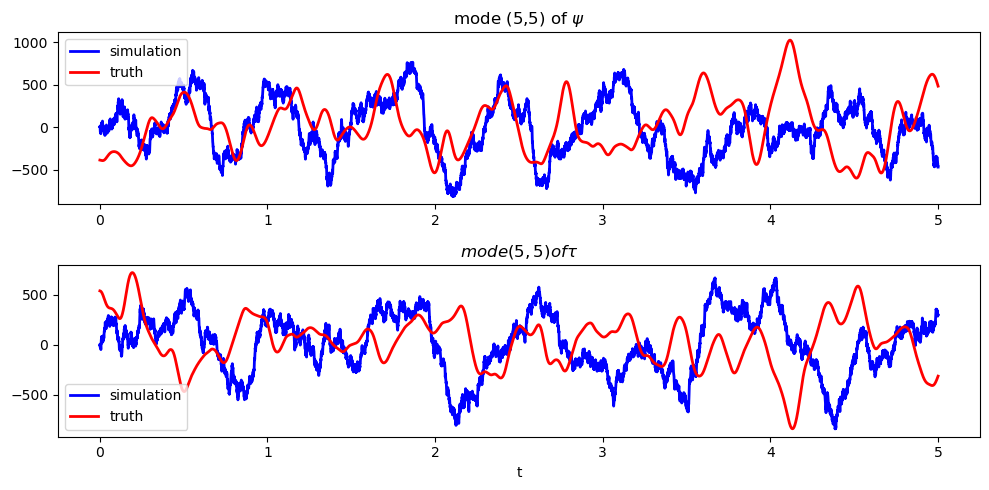

In [55]:
# Plotting trajectories
%matplotlib inline
mode = 5
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(np.arange(dt, (N+1)*dt, dt), np.real(psi_k[mode,mode,:]), 'b', linewidth=2, label='simulation')
plt.plot(np.arange(dt, (N+1)*dt, dt), np.real(psi_t_k[mode,mode,:]), 'r', linewidth=2, label='truth')
plt.title('mode (5,5) of $\psi$')
plt.legend()
# plt.xlabel('t')

plt.subplot(2, 1, 2)
plt.plot(np.arange(dt, (N+1)*dt, dt), np.real(tau_k[mode,mode,:]), 'b', linewidth=2, label='simulation')
plt.plot(np.arange(dt, (N+1)*dt, dt), np.real(tau_t_k[mode,mode,:]), 'r', linewidth=2, label='truth')
plt.title(r'$mode (5,5) of  \tau$')
plt.legend()
plt.xlabel('t')
plt.tight_layout()
plt.savefig('./LSM/psi_k_ou_truth_K128_beta22.png', dpi=100)
plt.show()

In [151]:
psi_t_k.shape

(128, 128, 10000)

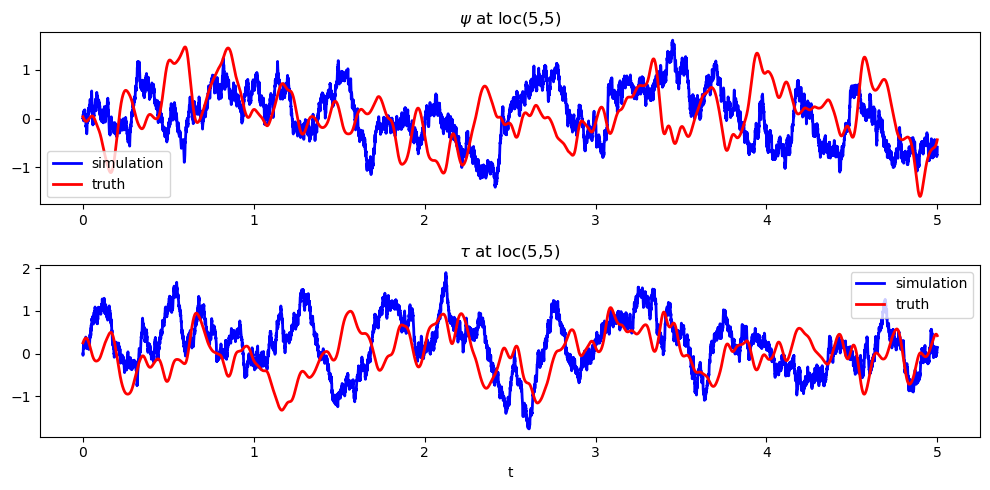

In [56]:
# Plotting trajectories
%matplotlib inline

loc = 5
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(np.arange(dt, (N+1)*dt, dt), np.real(psi_ifft[loc,loc,:]), 'b', linewidth=2, label='simulation')
plt.plot(np.arange(dt, (N+1)*dt, dt), np.real(psi_t_ifft[loc,loc,:]), 'r', linewidth=2, label='truth')
plt.title('$\psi$ at loc(5,5)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(np.arange(dt, (N+1)*dt, dt), np.real(tau_ifft[loc,loc,:]), 'b', linewidth=2, label='simulation')
plt.plot(np.arange(dt, (N+1)*dt, dt), np.real(tau_t_ifft[loc,loc,:]), 'r', linewidth=2, label='truth')
plt.title(r'$\tau$ at loc(5,5)' )
plt.legend()
plt.xlabel('t')
plt.tight_layout()
plt.savefig('./LSM/psi_ou_truth_K128_beta22.png', dpi=100)
plt.show()


In [157]:
np.array([r1[iky,ikx,:],r2[iky,ikx,:]]).T

array([[22.17506705+0.j,  0.04558809+0.j],
       [ 1.        +0.j,  1.        +0.j]])

In [28]:
# energy spectrum
def eigen2layer(K,cut,r1,r2,psi_k,tau_k):
    N = psi_k.shape[-1]
    psi1_k = np.zeros((K,K,N), dtype='complex')
    psi2_k = np.zeros((K,K,N), dtype='complex')
    kx = np.fft.fftfreq(K) * K
    ky = np.fft.fftfreq(K) * K
    for ikx,kx_value in enumerate(kx):
        for iky,ky_value in enumerate(ky): 
            if (ky_value == 0 and ky_value==0) or abs(kx_value) >= (K//2-cut) or abs(ky_value) >= (K//2-cut):  # Skip the case where k_mag is 0 and truncation
                continue
        eigenmat = np.array([r1[iky,ikx,:],r2[iky,ikx,:]])
        layer = eigenmat @ np.array([psi_k[iky,ikx,:],tau_k[iky,ikx,:]])
        psi1_k[iky,ikx,:] = layer[0,:] 
        psi2_k[iky,ikx,:] = layer[1,:] 
        
    return psi1_k, psi2_k
        
        
def ene_spectrum(psi_hat, K, kd, topo):
    hk = np.fft.fft2(topo)
    K_half = K // 2
    E_mode = np.zeros((K_half + 1,2))
    KE = np.zeros(K_half + 1)
    APE = np.zeros_like(KE)
    E = np.zeros_like(KE)
    ETP = np.zeros_like(KE)
    kx = np.fft.fftfreq(K) * K
    ky = np.fft.fftfreq(K) * K
    KX, KY = np.meshgrid(kx, ky)
    
    DY_psi_hat = psi_hat * (1j) * KY[:,:,None]
    DX_psi_hat = psi_hat * (1j) * KX[:,:,None]
    Laplacian = ((1j) * KY)**2 + ((1j) * KX)**2
    q_hat = np.zeros((K,K,2), dtype=complex)
    q_hat[:,:,0] = Laplacian * psi_hat[:,:,0] + kd**2/2*(psi_hat[:,:,1]-psi_hat[:,:,0])
    q_hat[:,:,1] = Laplacian * psi_hat[:,:,1] + kd**2/2*(psi_hat[:,:,0]-psi_hat[:,:,1]) + hk
    
    for jj in range(K):
        for ii in range(K):
            k = np.sqrt(KX[ii, jj]**2 + KY[ii, jj]**2)
            if np.ceil(k) <= K_half:
                r = k - np.floor(k)
                floor_k = int(np.floor(k))
                ceil_k = int(np.ceil(k))

                KE[floor_k] += (1 - r) * (k**2) * (np.abs(psi_hat[ii, jj, 0])**2 + np.abs(psi_hat[ii, jj, 1])**2)
                APE[floor_k] += (1 - r) * (.5 * kd**2) * np.abs(psi_hat[ii, jj, 0] - psi_hat[ii, jj, 1])**2
                E[floor_k] += (1 - r) * (np.abs(DX_psi_hat[ii, jj, 0])**2 + np.abs(DY_psi_hat[ii, jj, 0])**2 + np.abs(DX_psi_hat[ii, jj, 1])**2 + np.abs(DY_psi_hat[ii, jj, 1])**2 + (.5 * kd**2) * np.abs(psi_hat[ii, jj, 0] - psi_hat[ii, jj, 1])**2)
                ETP[floor_k] += (1 - r) * (np.abs(q_hat[ii, jj, 0])**2 + np.abs(q_hat[ii, jj, 1])**2)
                E_mode[floor_k, :] += (1 - r) * (np.abs(psi_hat[ii, jj, :])**2)                                
                
                if ceil_k != floor_k:  # Only update if ceil(k) and floor(k) are different
                    KE[ceil_k] += r * (k**2) * (np.abs(psi_hat[ii, jj, 0])**2 + np.abs(psi_hat[ii, jj, 1])**2)
                    APE[ceil_k] += r * (.5 * kd**2) * np.abs(psi_hat[ii, jj, 0] - psi_hat[ii, jj, 1])**2
                    E[ceil_k] += r * (np.abs(DX_psi_hat[ii, jj, 0])**2 + np.abs(DY_psi_hat[ii, jj, 0])**2 + np.abs(DX_psi_hat[ii, jj, 1])**2 + np.abs(DY_psi_hat[ii, jj, 1])**2 + (.5 * kd**2) * np.abs(psi_hat[ii, jj, 0] - psi_hat[ii, jj, 1])**2)
                    ETP[ceil_k] += r * (np.abs(q_hat[ii, jj, 0])**2 + np.abs(q_hat[ii, jj, 1])**2)
                    E_mode[ceil_k, :] += r * (np.abs(psi_hat[ii, jj, :])**2)                                

    KE = .5 * KE / (K**4)
    APE = .5 * APE / (K**4)
    E = .5 * E / (K**4)
    ETP = .5 * ETP / (K**4)
    E_mode = .5 * E_mode / (K**4)
    
    return KE, APE, E, ETP, E_mode
    

ke=0; ape=0; ene=0; etp=0; ke_ou=0; ape_ou=0; ene_ou=0; etp_ou=0; e_mode = 0; e_mode_ou = 0
t_avrg = 100
# psi_hat_t = np.concatenate((psi_t_k[:,:,None,-t_avrg:], tau_t_k[:,:,None,-t_avrg:]), axis=2)
psi_hat_t = np.concatenate((psi1_hat_t[:,:,None,-t_avrg:], psi2_hat_t[:,:,None,-t_avrg:]), axis=2)
for i in range(2,t_avrg+1):
    ike, iape, iene, ietp, e_mode = ene_spectrum(psi_hat_t[:,:,:,-i], K, kd, topo)
    ke += ike
    ape += iape
    ene += iene
    etp += ietp 
    e_mode += e_mode
    
ke = ke / t_avrg
ape = ape / t_avrg
ene = ene / t_avrg
etp = etp / t_avrg
e_mode = e_mode / t_avrg

psi1_k, psi2_k = eigen2layer(K,cut,r1,r2,psi_k,tau_k)
psi_hat = np.concatenate((psi1_k[:,:,None,-t_avrg:], psi2_k[:,:,None,-t_avrg:]), axis=2)
# psi_hat = np.concatenate((psi_k[:,:,None,-t_avrg:], tau_k[:,:,None,-t_avrg:]), axis=2)
ke_ou, ape_ou, ene_ou, etp_ou, e_mode_ou = ene_spectrum(psi_hat[:,:,:,-1], K, kd, topo)
for i in range(2,t_avrg+1):
    ike, iape, iene, ietp, e_mode_ou = ene_spectrum(psi_hat[:,:,:,-i], K, kd, topo)
    ke_ou += ike
    ape_ou += iape
    ene_ou += iene
    etp_ou += ietp
    e_mode_ou += e_mode_ou

ke_ou = ke_ou / t_avrg
ape_ou = ape_ou / t_avrg
ene_ou = ene_ou / t_avrg
etp_ou = etp_ou / t_avrg
e_mode_ou = e_mode_ou / t_avrg

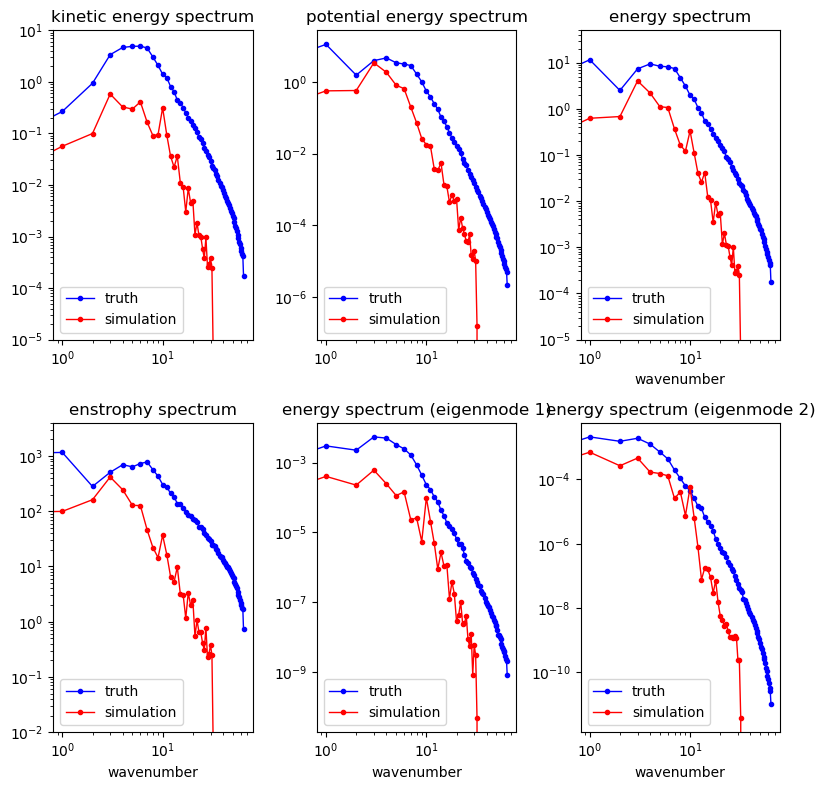

In [34]:
# spectrum of truth
plt.figure(2, figsize=(8, 8))  # Size in inches, converted from pixels assuming 72 DPI
plt.subplot(2, 3, 1)
plt.loglog(np.arange(0, K//2 + 1), ke, '.-b', linewidth=1, label='truth')
plt.loglog(np.arange(0, K//2 + 1), ke_ou, '.-r', linewidth=1, label='simulation')
plt.ylim([1e-5, 10])
plt.title('kinetic energy spectrum')
plt.legend()
# plt.xlabel('wavenumber')
plt.subplot(2, 3, 2)
plt.loglog(np.arange(0, K//2 + 1), ape, '.-b', linewidth=1, label='truth')
plt.loglog(np.arange(0, K//2 + 1), ape_ou, '.-r', linewidth=1, label='simulation')
plt.title('potential energy spectrum')
plt.legend()
# plt.xlabel('wavenumber')
# plt.tight_layout()  # Adjust subplots to fit into the figure area.
# plt.savefig('energy_topo10_nu2e-15_0228.png', dpi=150)  # Save the figure

# Figure 2
# plt.figure(3, figsize=(6, 4))  # Size in inches, converted from pixels assuming 72 DPI
plt.subplot(2, 3, 3)
plt.loglog(np.arange(0, K//2 + 1), ene, '.-b', linewidth=1, label='truth')
plt.loglog(np.arange(0, K//2 + 1), ene_ou, '.-r', linewidth=1, label='simulation')
plt.title('energy spectrum')
plt.ylim([1e-5, 50])
plt.legend()
plt.xlabel('wavenumber')
plt.subplot(2, 3, 4)
plt.loglog(np.arange(0, K//2 + 1), etp, '.-b', linewidth=1, label='truth')
plt.loglog(np.arange(0, K//2 + 1), etp_ou, '.-r', linewidth=1, label='simulation')
plt.ylim([1e-2, 4*1e3])
plt.title('enstrophy spectrum')
plt.xlabel('wavenumber')
plt.legend()
plt.subplot(2, 3, 5)
plt.loglog(np.arange(0, K//2 + 1), e_mode[:,0], '.-b', linewidth=1, label='truth')
plt.loglog(np.arange(0, K//2 + 1), e_mode_ou[:,0], '.-r', linewidth=1, label='simulation')
# plt.ylim([1e-2, 4*1e3])
plt.title('energy spectrum (eigenmode 1)')
plt.xlabel('wavenumber')
plt.legend()
plt.subplot(2, 3, 6)
plt.loglog(np.arange(0, K//2 + 1), e_mode[:,1], '.-b', linewidth=1, label='truth')
plt.loglog(np.arange(0, K//2 + 1), e_mode_ou[:,1], '.-r', linewidth=1, label='simulation')
# plt.ylim([1e-2, 4*1e3])
plt.title('energy spectrum (eigenmode 2)')
plt.xlabel('wavenumber')
plt.legend()
plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.savefig('./LSM/spectrum_layer_K128_beta22.png', dpi=150)  # Save the figure
plt.show()

### maybe it's because the constant mode 0 is removed?

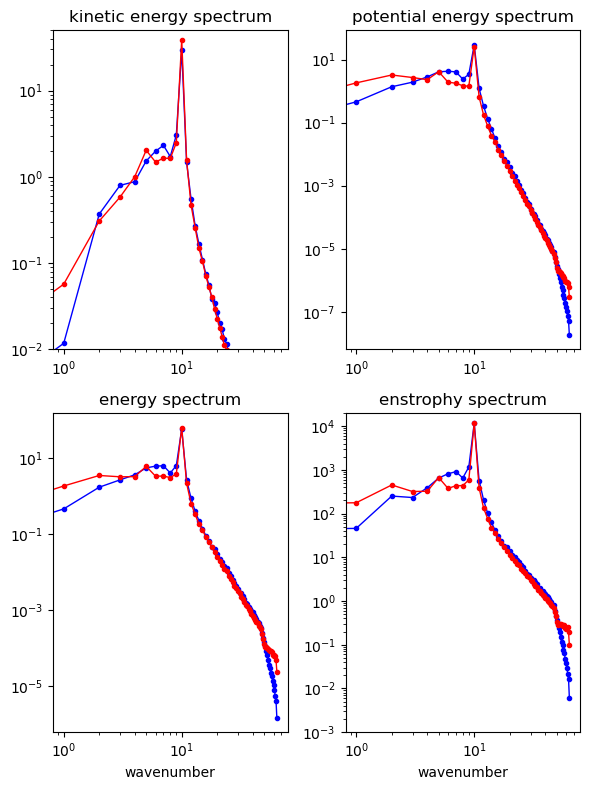

In [129]:
# spectrum of truth
plt.figure(2, figsize=(6, 8))  # Size in inches, converted from pixels assuming 72 DPI
plt.subplot(2, 2, 1)
plt.loglog(np.arange(0, K//2 + 1), ke, '.-b', linewidth=1, label='truth')
plt.loglog(np.arange(0, K//2 + 1), ke_ou, '.-r', linewidth=1, label='simulation')
plt.ylim([1e-2, 50])
plt.title('kinetic energy spectrum')
plt.legend()
# plt.xlabel('wavenumber')
plt.subplot(2, 2, 2)
plt.loglog(np.arange(0, K//2 + 1), ape, '.-b', linewidth=1, label='truth')
plt.loglog(np.arange(0, K//2 + 1), ape_ou, '.-r', linewidth=1, label='simulation')
plt.title('potential energy spectrum')
plt.legend()
# plt.xlabel('wavenumber')
# plt.tight_layout()  # Adjust subplots to fit into the figure area.
# plt.savefig('energy_topo10_nu2e-15_0228.png', dpi=150)  # Save the figure

# Figure 2
# plt.figure(3, figsize=(6, 4))  # Size in inches, converted from pixels assuming 72 DPI
plt.subplot(2, 2, 3)
plt.loglog(np.arange(0, K//2 + 1), ene, '.-b', linewidth=1, label='truth')
plt.loglog(np.arange(0, K//2 + 1), ene_ou, '.-r', linewidth=1, label='simulation')
plt.title('energy spectrum')
plt.xlabel('wavenumber')
plt.legend()
plt.subplot(2, 2, 4)
plt.loglog(np.arange(0, K//2 + 1), etp, '.-b', linewidth=1, label='truth')
plt.loglog(np.arange(0, K//2 + 1), etp_ou, '.-r', linewidth=1, label='simulation')
plt.ylim([1e-3, 2*1e4])
plt.title('enstrophy spectrum')
plt.legend()
plt.xlabel('wavenumber')
plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.savefig('./LSM/spectrum_eigen_K128.png', dpi=150)  # Save the figure
plt.show()

In [59]:
np.where(ke_ou==np.max(ke_ou))

(array([10]),)

# 2. Linear QG

The linearized QG model is the same one as used in solving eigenvalues, with only one **difference**: \
**the viscous term** is reserved to prevent the system blow up.

## load data

In [32]:
# load data
data_path = '/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/qg_2layer_topo/linQG_DATA_topo10_beta22_K16.mat'
with h5py.File(data_path, 'r') as file:
#     print("Keys: %s" % file.keys())
    psi1_hat_t = np.transpose(file['psi_1_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    psi2_hat_t = np.transpose(file['psi_2_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    dt = file['dt'][()][0,0]
    params_dataset = file['params']
    topo = params_dataset['H'][()] [0,0]
    kd = params_dataset['kd'][()] [0,0]
    U = params_dataset['U'][()] [0,0]
    kb = params_dataset['kb'][()] [0,0]
    beta = kb**2
    K = int(params_dataset['N'][()] [0,0])
    H = params_dataset['H'][()] [0,0]
    topo = file['topo'][()]
print('psi_hat_t.shape',psi1_hat_t.shape)
psi1_hat_t = psi1_hat_t['real'] + 1j * psi1_hat_t['imag']
psi2_hat_t = psi2_hat_t['real'] + 1j * psi2_hat_t['imag']
print('psi_hat_t.dtype',psi1_hat_t.dtype)

psi_hat_t.shape (16, 16, 100000)
psi_hat_t.dtype complex128


In [39]:
# load eigenvectors
eigens = np.load('../data/eigens_K16_beta22.npy', allow_pickle=True)
r1 = eigens.item()['r1']
r2 = eigens.item()['r2']
omega1 = eigens.item()['omega1']
omega2 = eigens.item()['omega2']

In [53]:
# Model calibration based on the ansatz of ACF
def CCF(data, gamma, omega):
    return np.exp(-gamma*data) * np.sin(omega*data)

def ACF(data, gamma, omega):
    return np.exp(-gamma*data) * np.cos(omega*data)


Lag = 40000  # lag for computing the ACF
tt = np.linspace(0, Lag*dt, num=Lag+1, endpoint=True) # time interval to plot the ACF or cross-correlation function
gamma_est = np.zeros((K,K,2))
omega_est = np.zeros((K,K,2))
f_est = np.zeros((K,K,2), dtype='complex')
sigma_est = np.zeros((K,K,2))
kx = np.fft.fftfreq(K) * K
ky = np.fft.fftfreq(K) * K
cut = 0

for ikx,kx_value in enumerate(kx):
    for iky,ky_value in enumerate(ky): 
        if (kx_value == 0 and ky_value==0) or abs(kx_value) >= (K//2-cut) or abs(ky_value) >= (K//2-cut):  # Skip the case where k_mag is 0 and truncation
            continue
        
#         print(kx_value, ky_value)

        eigenmat_inv = np.linalg.inv(np.array([r1[iky,ikx,:],r2[iky,ikx,:]]).T)
        eigenmode = eigenmat_inv @ np.array([psi1_hat_t[iky,ikx,:],psi2_hat_t[iky,ikx,:]])
        psi1_hat = eigenmode[0,:] 
        psi2_hat = eigenmode[1,:]
        acf_psi1 = acf(np.real(psi1_hat), nlags=Lag, fft=True)  # ACF of the real part
        acf_psi2 = acf(np.real(psi2_hat), nlags=Lag, fft=True)  # ACF of the real part
#         ccf_psi1 = -ccf(np.real(psi1_hat), np.imag(psi1_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts 
#         ccf_psi2 = -ccf(np.real(psi2_hat), np.imag(psi2_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts

        # Fitting the cross-correlation function
        x0 = [0.5, 0.5]
        x1, _ = curve_fit(ACF, tt, acf_psi1, p0=x0, check_finite=True, maxfev=2000)
        # Estimated values
        gamma1_est = x1[0]
        omega1_est = x1[1]
        m1 = np.mean(psi1_hat)
        E1 = np.var(psi1_hat)
        T1 = gamma1_est / (gamma1_est**2 + omega1_est**2)
        theta1 = omega1_est / (gamma1_est**2 + omega1_est**2)
        f1_est = m1 * (T1 - 1j*theta1) / (T1**2 + theta1**2)
        sigma1_est = np.sqrt(2*E1*T1 / (T1**2 + theta1**2))
        gamma_est[iky,ikx,0] = gamma1_est; omega_est[iky,ikx,0] = omega1_est; f_est[iky,ikx,0] = f1_est; sigma_est[iky,ikx,0] = sigma1_est;
        
        x2, _ = curve_fit(ACF, tt, acf_psi2, p0=x0, check_finite=True, maxfev=2000)
        # Estimated values
        gamma2_est = x2[0]
        omega2_est = x2[1]
        m2 = np.mean(psi2_hat)
        E2 = np.var(psi2_hat)
        T2 = gamma2_est / (gamma2_est**2 + omega2_est**2)
        theta2 = omega2_est / (gamma2_est**2 + omega2_est**2)
        f2_est = m2 * (T2 - 1j*theta2) / (T2**2 + theta2**2)
        sigma2_est = np.sqrt(2*E2*T2 / (T2**2 + theta2**2))
        gamma_est[iky,ikx,1] = gamma2_est; omega_est[iky,ikx,1] = omega2_est; f_est[iky,ikx,1] = f2_est; sigma_est[iky,ikx,1] = sigma2_est;


In [54]:
# save fitted parameters
est_params = {
    'gamma': gamma_est,
    'omega': omega_est,
    'f': f_est,
    'sigma': sigma_est,
    'cut': cut
}
np.save('../data/est_paras_ou_K16_beta22_linQG.npy', est_params)

In [55]:
# Model calibration based on the ansatz of CCF
def CCF(data, gamma, omega):
    return np.exp(-gamma*data) * np.sin(omega*data)

def ACF(data, gamma, omega):
    return np.exp(-gamma*data) * np.cos(omega*data)


Lag = 40000  # lag for computing the ACF
tt = np.linspace(0, Lag*dt, num=Lag+1, endpoint=True) # time interval to plot the ACF or cross-correlation function
gamma_est = np.zeros((K,K,2))
omega_est = np.zeros((K,K,2))
f_est = np.zeros((K,K,2), dtype='complex')
sigma_est = np.zeros((K,K,2))
kx = np.fft.fftfreq(K) * K
ky = np.fft.fftfreq(K) * K
cut = 0

for ikx,kx_value in enumerate(kx):
    for iky,ky_value in enumerate(ky): 
        if (kx_value == 0 and ky_value==0) or abs(kx_value) >= (K//2-cut) or abs(ky_value) >= (K//2-cut):  # Skip the case where k_mag is 0 and truncation
            continue
        
#         print(kx_value, ky_value)

        eigenmat_inv = np.linalg.inv(np.array([r1[iky,ikx,:],r2[iky,ikx,:]]).T)
        eigenmode = eigenmat_inv @ np.array([psi1_hat_t[iky,ikx,:],psi2_hat_t[iky,ikx,:]])
        psi1_hat = eigenmode[0,:] 
        psi2_hat = eigenmode[1,:]
#         acf_psi1 = acf(np.real(psi1_hat), nlags=Lag, fft=True)  # ACF of the real part
#         acf_psi2 = acf(np.real(psi2_hat), nlags=Lag, fft=True)  # ACF of the real part
        ccf_psi1 = -ccf(np.real(psi1_hat), np.imag(psi1_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts 
        ccf_psi2 = -ccf(np.real(psi2_hat), np.imag(psi2_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts

        # Fitting the cross-correlation function
        x0 = [0.5, 0.5]
        x1, _ = curve_fit(CCF, tt, ccf_psi1, p0=x0, check_finite=True, maxfev=8000)
        # Estimated values
        gamma1_est = x1[0]
        omega1_est = x1[1]
        gamma_est[iky,ikx,0] = gamma1_est; omega_est[iky,ikx,0] = omega1_est;

        x2, _ = curve_fit(CCF, tt, ccf_psi2, p0=x0, check_finite=True, maxfev=8000)
        # Estimated values
        gamma2_est = x2[0]
        omega2_est = x2[1]
        gamma_est[iky,ikx,1] = gamma2_est; omega_est[iky,ikx,1] = omega2_est;


In [56]:
# save fitted parameters
est_params = {
    'gamma': gamma_est,
    'omega': omega_est,
    'cut': cut
}
np.save('../data/est_paras_ou_K16_beta22_linQG_ccf.npy', est_params)

In [108]:
# calibrate the sign of ACF-estimated omega_k according to CCF-estimated omega_k
params = np.load('../data/est_paras_ou_K16_beta22_linQG.npy', allow_pickle=True).item()
gamma, omega, f, sigma = params['gamma'], params['omega'], params['f'], params['sigma']

sign1 = np.sign(omega)
sign2 = np.sign(omega_est)
sign2_corrected = np.where((sign1 == 0) & (sign2 == 0), 0, sign2)
omega_est_ca = np.abs(omega) * sign2_corrected

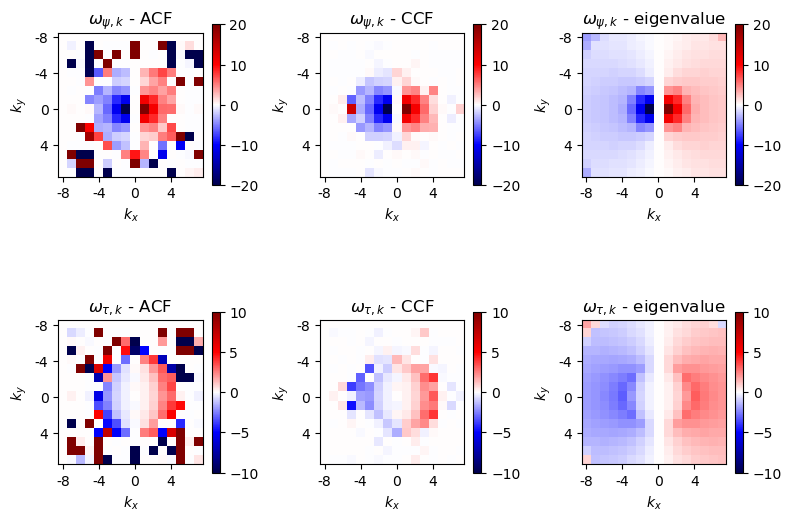

In [116]:
# Create a figure for the plots
fig = plt.figure(figsize=(8, 6))

matrix1 = omega_est_ca[:,:,0]
matrix2 = omega_est[:,:,0]
matrix1 = np.roll(matrix1, shift=K//2, axis=0)
matrix1 = np.roll(matrix1, shift=K//2, axis=1)
matrix2 = np.roll(matrix2, shift=K//2, axis=0) 
matrix2 = np.roll(matrix2, shift=K//2, axis=1)

lim1 = 20
lim2 = 10
# Plot for matrix1
ax1 = fig.add_subplot(231)  # 1 row, 2 columns, 1st subplot
surf1 = ax1.imshow(matrix1, cmap='seismic', vmin=-lim1, vmax=lim1)
ax1.set_title(r'$\omega_{\psi,k}$ - ACF')
ax1.set_xlabel('$k_x$')
ax1.set_ylabel('$k_y$')
# ax1.set_zlabel('Value')
ax1.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax1.set_xticklabels(kx[::K//4].astype(int))
ax1.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax1.set_yticklabels(kx[::K//4].astype(int))
fig.colorbar(surf1, shrink=0.6)#, ax=ax1, shrink=0.5, aspect=12)
# lim1 = np.max(np.abs(matrix1))

# Plot for matrix2
ax2 = fig.add_subplot(232)  # 1 row, 2 columns, 2nd subplot
surf2 = ax2.imshow(matrix2, cmap='seismic', vmin=-lim1, vmax=lim1)
ax2.set_title(r'$\omega_{\psi,k}$ - CCF')
ax2.set_xlabel('$k_x$')
ax2.set_ylabel('$k_y$')
# ax2.set_zlabel('Value')
# ax2.set_zlim(-60, 60)
ax2.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax2.set_xticklabels(kx[::K//4].astype(int))
ax2.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax2.set_yticklabels(kx[::K//4].astype(int))
fig.colorbar(surf2, shrink=0.6)#, ax=ax2, shrink=0.5, aspect=12)

matrix1 = omega_est_ca[:,:,1]
matrix2 = omega_est[:,:,1]
matrix1 = np.roll(matrix1, shift=K//2, axis=0)
matrix1 = np.roll(matrix1, shift=K//2, axis=1)
matrix2 = np.roll(matrix2, shift=K//2, axis=0) 
matrix2 = np.roll(matrix2, shift=K//2, axis=1)

# Plot for matrix1
ax3 = fig.add_subplot(234)  # 1 row, 2 columns, 1st subplot
surf1 = ax3.imshow(matrix1, cmap='seismic', vmin=-lim2, vmax=lim2)
ax3.set_title(r'$\omega_{\tau,k}$ - ACF')
ax3.set_xlabel('$k_x$')
ax3.set_ylabel('$k_y$')
# ax1.set_zlabel('Value')
ax3.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax3.set_xticklabels(kx[::K//4].astype(int))
ax3.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax3.set_yticklabels(kx[::K//4].astype(int))
fig.colorbar(surf1, shrink=0.6)#, ax=ax1, shrink=0.5, aspect=12)
# lim1 = np.max(np.abs(matrix1)) / 100

# Plot for matrix2
ax4 = fig.add_subplot(235)  # 1 row, 2 columns, 2nd subplot
surf2 = ax4.imshow(matrix2, cmap='seismic', vmin=-lim2, vmax=lim2)
ax4.set_title(r'$\omega_{\tau,k}$ - CCF')
ax4.set_xlabel('$k_x$')
ax4.set_ylabel('$k_y$')
# ax2.set_zlabel('Value')
# ax2.set_zlim(-60, 60)
ax4.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax4.set_xticklabels(kx[::K//4].astype(int))
ax4.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax4.set_yticklabels(kx[::K//4].astype(int))
fig.colorbar(surf2, shrink=0.6)#, ax=ax2, shrink=0.5, aspect=12)

matrix1 = omega1.real # np.abs(omega[:,:,0])-np.abs(omega_est[:,:,0])
matrix2 = omega2.real # p.abs(omega[:,:,1])-np.abs(omega_est[:,:,1])
matrix1 = np.roll(matrix1, shift=K//2, axis=0)
matrix1 = np.roll(matrix1, shift=K//2, axis=1)
matrix2 = np.roll(matrix2, shift=K//2, axis=0) 
matrix2 = np.roll(matrix2, shift=K//2, axis=1)

# Plot for matrix1
ax5 = fig.add_subplot(233)  # 1 row, 2 columns, 1st subplot
surf1 = ax5.imshow(matrix1, cmap='seismic', vmin=-lim1, vmax=lim1)
ax5.set_title(r'$\omega_{\psi,k}$ - eigenvalue')
ax5.set_xlabel('$k_x$')
ax5.set_ylabel('$k_y$')
# ax1.set_zlabel('Value')
ax5.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax5.set_xticklabels(kx[::K//4].astype(int))
ax5.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax5.set_yticklabels(kx[::K//4].astype(int))
fig.colorbar(surf1, shrink=0.6)#, ax=ax1, shrink=0.5, aspect=12)

# Plot for matrix2
ax6 = fig.add_subplot(236)  # 1 row, 2 columns, 2nd subplot
surf2 = ax6.imshow(matrix2, cmap='seismic', vmin=-lim2, vmax=lim2)
ax6.set_title(r'$\omega_{\tau,k}$ - eigenvalue')
ax6.set_xlabel('$k_x$')
ax6.set_ylabel('$k_y$')
# ax2.set_zlabel('Value')
# ax2.set_zlim(-60, 60)
ax6.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax6.set_xticklabels(kx[::K//4].astype(int))
ax6.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax6.set_yticklabels(kx[::K//4].astype(int))
fig.colorbar(surf2, shrink=0.6)#, ax=ax2, shrink=0.5, aspect=12)

plt.tight_layout()
# plt.savefig('./LSM/omega_compare_K128.png',dpi=150)
plt.show()

## trouble shooting - mode 10

In [60]:
params = np.load('../data/est_paras_ou_K128.npy', allow_pickle=True).item()
gamma, omega, f, sigma = params['gamma'], params['omega'], params['f'], params['sigma']
eigens = np.load('../data/eigens_K128.npy', allow_pickle=True)
r1 = eigens.item()['r1']
r2 = eigens.item()['r2']

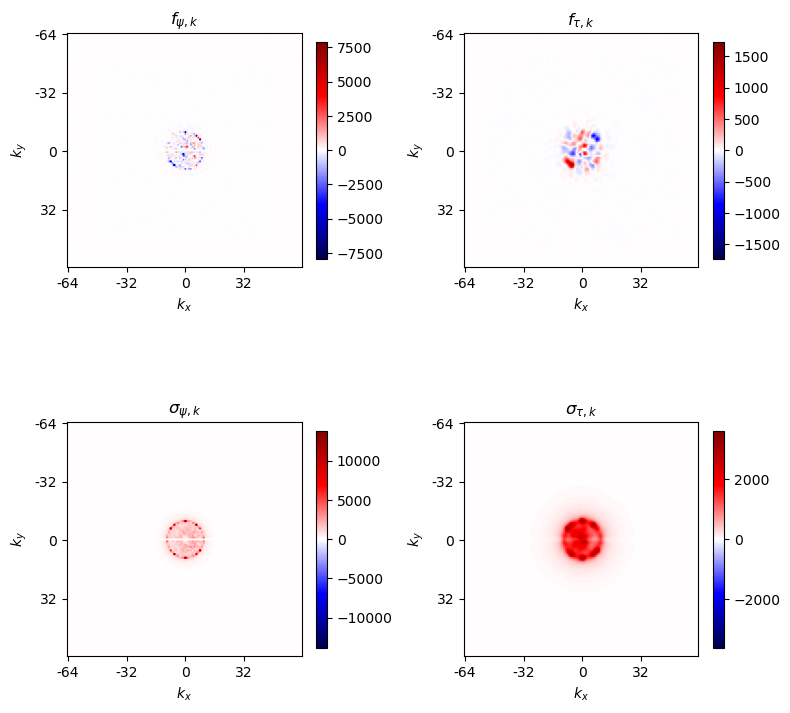

In [61]:
# plot omega
from scipy.ndimage import gaussian_filter

%matplotlib inline

matrix1 = f[:,:,0].real
matrix2 = f[:,:,1].real
matrix1 = np.roll(matrix1, shift=K//2, axis=0)
matrix1 = np.roll(matrix1, shift=K//2, axis=1)
matrix2 = np.roll(matrix2, shift=K//2, axis=0) 
matrix2 = np.roll(matrix2, shift=K//2, axis=1)

matrix3 = sigma[:,:,0]
matrix4 = sigma[:,:,1]
matrix3 = np.roll(matrix3, shift=K//2, axis=0)
matrix3 = np.roll(matrix3, shift=K//2, axis=1)
matrix4 = np.roll(matrix4, shift=K//2, axis=0) 
matrix4 = np.roll(matrix4, shift=K//2, axis=1)

# Generate grid indices for the KxK matrices
x = np.linspace(0, K, num=K, endpoint=False) #np.fft.fftfreq(K) * K
y = np.linspace(0, K, num=K, endpoint=False) #np.fft.fftfreq(K) * K
X, Y = np.meshgrid(x, y)
kx = np.roll(np.fft.fftfreq(K) * K, shift=K//2)
ky = np.roll(np.fft.fftfreq(K) * K, shift=K//2)
smoothed_matrix2 = gaussian_filter(matrix2, sigma=1)
smoothed_matrix4 = gaussian_filter(matrix4, sigma=1)

# Create a figure for the plots
fig = plt.figure(figsize=(8, 8))

# Plot for matrix1
ax1 = fig.add_subplot(221)  # 1 row, 2 columns, 1st subplot
surf1 = ax1.imshow(matrix1, cmap='seismic', vmin=-np.max(np.abs(matrix1)), vmax=np.max(np.abs(matrix1)))
ax1.set_title(r'$f_{\psi,k}$')
ax1.set_xlabel('$k_x$')
ax1.set_ylabel('$k_y$')
# ax1.set_zlabel('Value')
ax1.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax1.set_xticklabels(kx[::32].astype(int))
ax1.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax1.set_yticklabels(kx[::32].astype(int))
fig.colorbar(surf1, shrink=0.6)#, ax=ax1, shrink=0.5, aspect=12)

# Plot for matrix2
ax2 = fig.add_subplot(222)  # 1 row, 2 columns, 2nd subplot
surf2 = ax2.imshow(smoothed_matrix2, cmap='seismic', vmin=-np.max(np.abs(smoothed_matrix2)), vmax=np.max(np.abs(smoothed_matrix2)))
ax2.set_title(r'$f_{\tau,k}$')
ax2.set_xlabel('$k_x$')
ax2.set_ylabel('$k_y$')
# ax2.set_zlabel('Value')
# ax2.set_zlim(-60, 60)
ax2.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax2.set_xticklabels(kx[::32].astype(int))
ax2.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax2.set_yticklabels(kx[::32].astype(int))
fig.colorbar(surf2, shrink=0.6)#, ax=ax2, shrink=0.5, aspect=12)

# Plot for matrix1
ax3 = fig.add_subplot(223)  # 1 row, 2 columns, 1st subplot
surf3 = ax3.imshow(matrix3, cmap='seismic', vmin=-np.max(np.abs(matrix3)), vmax=np.max(np.abs(matrix3)))
ax3.set_title(r'$\sigma_{\psi,k}$')
ax3.set_xlabel('$k_x$')
ax3.set_ylabel('$k_y$')
# ax3.set_zlabel('Value')
ax3.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax3.set_xticklabels(kx[::32].astype(int))
ax3.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax3.set_yticklabels(kx[::32].astype(int))
fig.colorbar(surf3, shrink=0.6)#, ax=ax3, shrink=0.5, aspect=12)

# Plot for matrix2
ax4 = fig.add_subplot(224)  # 1 row, 2 columns, 2nd subplot
surf4 = ax4.imshow(smoothed_matrix4, cmap='seismic', vmin=-np.max(np.abs(smoothed_matrix4)), vmax=np.max(np.abs(smoothed_matrix4)))
ax4.set_title(r'$\sigma_{\tau,k}$')
ax4.set_xlabel('$k_x$')
ax4.set_ylabel('$k_y$')
# ax4.set_zlabel('Value')
# ax4.set_zlim(-np.max(np.abs(smoothed_matrix4)), -np.max(np.abs(smoothed_matrix4)))
ax4.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax4.set_xticklabels(kx[::32].astype(int))
ax4.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax4.set_yticklabels(kx[::32].astype(int))
fig.colorbar(surf4, shrink=0.6)#, ax=ax4, shrink=0.5, aspect=12)

plt.tight_layout()
# plt.savefig('./LSM/omega_compare.png',dpi=150)
plt.show()

In [62]:
def find_indices(kx, ky):
    # List to store the pairs of indices
    indices_x = []
    indices_y = []

    # Iterate through each element in kx
    for i in range(len(kx)):
        # Iterate through each element in ky
        for j in range(len(ky)):
            # Check if the condition kx[i]^2 + ky[j]^2 = 100 is met
            if kx[i]**2 + ky[j]**2 == 100:
                # If condition is met, add the pair of indices (i, j) to the list
                indices_x.append(i)
                indices_y.append(j)

    return indices_x,indices_y

K=128
kx = np.fft.fftfreq(K) * K
ky = np.fft.fftfreq(K) * K
index_x, index_y = find_indices(kx,ky)

In [63]:
index_y

[10, 118, 8, 120, 6, 122, 0, 0, 6, 122, 8, 120]

In [65]:
gamma[index_x, index_y, :]

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [13.63268869, 13.56961558],
       [ 3.79311704,  3.4649007 ],
       [ 7.65283991,  7.91459342],
       [12.18252701, 12.30155668],
       [14.92285486, 11.19291434],
       [14.9228549 , 11.19291435],
       [12.18252701, 12.30155668],
       [ 7.6528399 ,  7.91459342],
       [ 3.79311703,  3.4649007 ],
       [13.63268875, 13.56961558]])

In [64]:
omega[index_x, index_y, :]

array([[  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  5.69800624,   3.46402669],
       [-11.74882254, -11.74401019],
       [  6.46110491,   6.24457531],
       [ 16.99191606,  16.97977139],
       [ -7.92700853, -14.78597882],
       [ -7.92700865, -14.78597881],
       [ 16.99191606,  16.97977138],
       [  6.46110491,   6.24457532],
       [-11.74882254, -11.74401019],
       [  5.69800616,   3.46402674]])

In [66]:
f[index_x, index_y, :]

array([[    0.           +0.j        ,     0.           +0.j        ],
       [    0.           +0.j        ,     0.           +0.j        ],
       [-2844.65331866-3069.94000436j,  2276.11412696+3433.06713709j],
       [-5659.60921917+5229.16508599j,  5617.62681762-5318.43330748j],
       [ 2832.83935034 +631.05691186j, -3028.88870449 -841.15393374j],
       [-7916.78387065-4220.99961646j,  8250.62067562+4433.87651914j],
       [-2852.13835532-4017.87330338j,  1146.68208347+5456.83832608j],
       [-4925.95563218 -113.84399551j,  4940.75589925+2584.7428258j ],
       [ 6538.75380288+6143.04511842j, -6783.9019308 -6458.38037666j],
       [ -147.11763091-2898.54584436j,   113.38414176+3141.47270659j],
       [ 7648.90768631 +932.49944154j, -7604.91187343-1417.31411682j],
       [  186.05645595+4181.14424406j,   352.06920831-4103.98498916j]])

In [67]:
sigma[index_x, index_y, :]

array([[    0.        ,     0.        ],
       [    0.        ,     0.        ],
       [13812.55411613, 13888.05639449],
       [ 6632.86429584,  6347.8308942 ],
       [10314.15280485, 10556.67154035],
       [13441.70827609, 13497.58752917],
       [13732.11587021, 11965.69647127],
       [13732.11588902, 11965.69647739],
       [13441.70827592, 13497.58752826],
       [10314.15280214, 10556.67154106],
       [ 6632.86429507,  6347.83089356],
       [13812.55414828, 13888.05639443]])

In [27]:
r1[index_x, index_y, :]

array([[1.08333333+0.j, 1.        +0.j],
       [1.08333333+0.j, 1.        +0.j],
       [1.08333333+0.j, 1.        +0.j],
       [1.08333333+0.j, 1.        +0.j],
       [1.08333333+0.j, 1.        +0.j],
       [1.08333333+0.j, 1.        +0.j],
       [1.08333333+0.j, 1.        +0.j],
       [1.08333333+0.j, 1.        +0.j],
       [1.08333333+0.j, 1.        +0.j],
       [1.08333333+0.j, 1.        +0.j],
       [1.08333333+0.j, 1.        +0.j],
       [1.08333333+0.j, 1.        +0.j]])

In [28]:
r2[index_x, index_y, :]

array([[1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j]])

# solving eigenequation

In [52]:
import sympy as sp
from sympy import symbols, sqrt, simplify, factor

# Define symbolic variables
kx, ky, kd, U, beta = sp.symbols('k_x k_y k_d U beta')
k_mag = kx**2 + ky**2  # Magnitude of the wavevector k

# Define the matrices A_k and B_k
A_k = sp.Matrix([
    [-(k_mag + kd/2), kd/2],
    [kd/2, -(k_mag + kd/2)]
])

B_k = kx * sp.Matrix([
    [beta - k_mag * U + kd/2 * U, kd/2 * U],
    [-kd/2 * U, beta + k_mag * U - kd/2 * U]
])

# Compute C_k = -A_k.inv() * B_k
C_k = -A_k.inv() * B_k


In [48]:
A_k

Matrix([
[-k_d/2 - k_x**2 - k_y**2,                    k_d/2],
[                   k_d/2, -k_d/2 - k_x**2 - k_y**2]])

In [49]:
B_k

Matrix([
[k_x*(U*k_d/2 - U*(k_x**2 + k_y**2) + beta),                                 U*k_d*k_x/2],
[                              -U*k_d*k_x/2, k_x*(-U*k_d/2 + U*(k_x**2 + k_y**2) + beta)]])

In [50]:
# Solve the eigenvalue problem for C_k
eigenvals = C_k.eigenvals()
eigenvects = C_k.eigenvects()

print("Eigenvalues (omega_k):", eigenvals)
print("Eigenvectors (r_k):", eigenvects)


Eigenvalues (omega_k): {beta*k_x*(k_d + 2*k_x**2 + 2*k_y**2)/(2*(k_x**2 + k_y**2)*(k_d + k_x**2 + k_y**2)) - k_x*sqrt(-4*U**2*k_d**2*k_x**4 - 8*U**2*k_d**2*k_x**2*k_y**2 - 4*U**2*k_d**2*k_y**4 + 4*U**2*k_x**8 + 16*U**2*k_x**6*k_y**2 + 24*U**2*k_x**4*k_y**4 + 16*U**2*k_x**2*k_y**6 + 4*U**2*k_y**8 + beta**2*k_d**2)/(2*(k_d*k_x**2 + k_d*k_y**2 + k_x**4 + 2*k_x**2*k_y**2 + k_y**4)): 1, beta*k_x*(k_d + 2*k_x**2 + 2*k_y**2)/(2*(k_x**2 + k_y**2)*(k_d + k_x**2 + k_y**2)) + k_x*sqrt(-4*U**2*k_d**2*k_x**4 - 8*U**2*k_d**2*k_x**2*k_y**2 - 4*U**2*k_d**2*k_y**4 + 4*U**2*k_x**8 + 16*U**2*k_x**6*k_y**2 + 24*U**2*k_x**4*k_y**4 + 16*U**2*k_x**2*k_y**6 + 4*U**2*k_y**8 + beta**2*k_d**2)/(2*(k_d*k_x**2 + k_d*k_y**2 + k_x**4 + 2*k_x**2*k_y**2 + k_y**4)): 1}
Eigenvectors (r_k): [(beta*k_x*(k_d + 2*k_x**2 + 2*k_y**2)/(2*(k_x**2 + k_y**2)*(k_d + k_x**2 + k_y**2)) - k_x*sqrt(-4*U**2*k_d**2*k_x**4 - 8*U**2*k_d**2*k_x**2*k_y**2 - 4*U**2*k_d**2*k_y**4 + 4*U**2*k_x**8 + 16*U**2*k_x**6*k_y**2 + 24*U**2*k_x**4*k_y**4

In [60]:
eigenvalue1 = beta * kx * (kd + 2*kx**2 + 2*ky**2) / (2*(kx**2 + ky**2)*(kd + kx**2 + ky**2)) - kx * sqrt(-4*U**2*kd**2*kx**4 - 8*U**2*kd**2*kx**2*ky**2 - 4*U**2*kd**2*ky**4 + 4*U**2*kx**8 + 16*U**2*kx**6*ky**2 + 24*U**2*kx**4*ky**4 + 16*U**2*kx**2*ky**6 + 4*U**2*ky**8 + beta**2*kd**2) / (2*(kd*kx**2 + kd*ky**2 + kx**4 + 2*kx**2*ky**2 + ky**4))
eigenvalue2 = beta * kx * (kd + 2*kx**2 + 2*ky**2) / (2*(kx**2 + ky**2)*(kd + kx**2 + ky**2)) + kx * sqrt(-4*U**2*kd**2*kx**4 - 8*U**2*kd**2*kx**2*ky**2 - 4*U**2*kd**2*ky**4 + 4*U**2*kx**8 + 16*U**2*kx**6*ky**2 + 24*U**2*kx**4*ky**4 + 16*U**2*kx**2*ky**6 + 4*U**2*ky**8 + beta**2*kd**2) / (2*(kd*kx**2 + kd*ky**2 + kx**4 + 2*kx**2*ky**2 + ky**4))

# Simplify the eigenvalues
simplified_eigenvalue1 = simplify(eigenvalue1)
simplified_eigenvalue2 = simplify(eigenvalue2)

# Optionally, factor the eigenvalues
factored_eigenvalue1 = factor(simplified_eigenvalue1)
factored_eigenvalue2 = factor(simplified_eigenvalue2)

# Output the simplified and factored eigenvalues
print("Simplified Eigenvalue 1:", simplified_eigenvalue1)
print("Simplified Eigenvalue 2:", simplified_eigenvalue2)
print("Factored Eigenvalue 1:", factored_eigenvalue1)
print("Factored Eigenvalue 2:", factored_eigenvalue2)

Simplified Eigenvalue 1: k_x*(beta*k_d + 2*beta*k_x**2 + 2*beta*k_y**2 - sqrt(-4*U**2*k_d**2*k_x**4 - 8*U**2*k_d**2*k_x**2*k_y**2 - 4*U**2*k_d**2*k_y**4 + 4*U**2*k_x**8 + 16*U**2*k_x**6*k_y**2 + 24*U**2*k_x**4*k_y**4 + 16*U**2*k_x**2*k_y**6 + 4*U**2*k_y**8 + beta**2*k_d**2))/(2*(k_d*k_x**2 + k_d*k_y**2 + k_x**4 + 2*k_x**2*k_y**2 + k_y**4))
Simplified Eigenvalue 2: k_x*(beta*k_d + 2*beta*k_x**2 + 2*beta*k_y**2 + sqrt(-4*U**2*k_d**2*k_x**4 - 8*U**2*k_d**2*k_x**2*k_y**2 - 4*U**2*k_d**2*k_y**4 + 4*U**2*k_x**8 + 16*U**2*k_x**6*k_y**2 + 24*U**2*k_x**4*k_y**4 + 16*U**2*k_x**2*k_y**6 + 4*U**2*k_y**8 + beta**2*k_d**2))/(2*(k_d*k_x**2 + k_d*k_y**2 + k_x**4 + 2*k_x**2*k_y**2 + k_y**4))
Factored Eigenvalue 1: k_x*(beta*k_d + 2*beta*k_x**2 + 2*beta*k_y**2 - sqrt(-4*U**2*k_d**2*k_x**4 - 8*U**2*k_d**2*k_x**2*k_y**2 - 4*U**2*k_d**2*k_y**4 + 4*U**2*k_x**8 + 16*U**2*k_x**6*k_y**2 + 24*U**2*k_x**4*k_y**4 + 16*U**2*k_x**2*k_y**6 + 4*U**2*k_y**8 + beta**2*k_d**2))/(2*(k_x**2 + k_y**2)*(k_d + k_x**2 + k_y**

In [59]:
eigenvals.keys()

dict_keys([beta*k_x*(k_d + 2*k_x**2 + 2*k_y**2)/(2*(k_x**2 + k_y**2)*(k_d + k_x**2 + k_y**2)) - k_x*sqrt(-4*U**2*k_d**2*k_x**4 - 8*U**2*k_d**2*k_x**2*k_y**2 - 4*U**2*k_d**2*k_y**4 + 4*U**2*k_x**8 + 16*U**2*k_x**6*k_y**2 + 24*U**2*k_x**4*k_y**4 + 16*U**2*k_x**2*k_y**6 + 4*U**2*k_y**8 + beta**2*k_d**2)/(2*(k_d*k_x**2 + k_d*k_y**2 + k_x**4 + 2*k_x**2*k_y**2 + k_y**4)), beta*k_x*(k_d + 2*k_x**2 + 2*k_y**2)/(2*(k_x**2 + k_y**2)*(k_d + k_x**2 + k_y**2)) + k_x*sqrt(-4*U**2*k_d**2*k_x**4 - 8*U**2*k_d**2*k_x**2*k_y**2 - 4*U**2*k_d**2*k_y**4 + 4*U**2*k_x**8 + 16*U**2*k_x**6*k_y**2 + 24*U**2*k_x**4*k_y**4 + 16*U**2*k_x**2*k_y**6 + 4*U**2*k_y**8 + beta**2*k_d**2)/(2*(k_d*k_x**2 + k_d*k_y**2 + k_x**4 + 2*k_x**2*k_y**2 + k_y**4))])

### Verify that symbolic results are correct by pluggin real numbers

In [116]:
# built-in function
import numpy as np

# Assign real numbers to the variables
kx_value = 1.0  # Example value for kx
ky_value = 1.0  # Example value for ky
kd_value = 0.5  # Example value for kd
U_value = 2.0   # Example value for U
beta_value = 1.0  # Example value for beta

# Calculate k_mag
k_mag = kx_value**2 + ky_value**2

# Define the matrices A_k and B_k
A_k = np.array([
    [-(k_mag + kd_value**2/2), kd_value**2/2],
    [kd_value**2/2, -(k_mag + kd_value**2/2)]
])

B_k = kx_value * np.array([
    [beta_value - k_mag * U_value + kd_value**2/2 * U_value, kd_value**2/2 * U_value],
    [-kd_value**2/2 * U_value, beta_value + k_mag * U_value - kd_value**2/2 * U_value]
])

# Compute C_k = -np.linalg.inv(A_k) @ B_k
C_k = -np.linalg.inv(A_k) @ B_k

# Solve the eigenvalue problem
eigenvalues, eigenvectors = np.linalg.eig(C_k)

# Print the results
print("Eigenvalues:", eigenvalues)
print("Eigenvectors:", eigenvectors[:,0],eigenvectors[:,1])


Eigenvalues: [-1.2918307   2.23627515]
Eigenvectors: [-0.99849642 -0.05481687] [-0.07040978 -0.99751815]


In [117]:
print(eigenvalues[0] * eigenvectors[:,0])
print(C_k @ eigenvectors[:,0][:, None])

[1.28988834 0.07081412]
[[1.28988834]
 [0.07081412]]


In [113]:
# Compute omega_k1 and omega_k2 using the symbolic formula
omega_k2 = (kx_value * (beta_value * (kd_value**2 + 2 * k_mag) + np.sqrt(beta_value**2 * kd_value**4 + 4 * k_mag**2 * (-kd_value**4 + k_mag**2) * U_value**2))) / (2 * k_mag * (kd_value**2 + k_mag))
omega_k1 = kx_value * (beta_value * (kd_value**2 + 2 * k_mag) - np.sqrt(beta_value**2 * kd_value**4 + 4 * k_mag**2 * (-kd_value**4 + k_mag**2) * U_value**2)) / (2 * k_mag * (kd_value**2 + k_mag))

# Compute r_k1 and r_k2
r_k2 = np.array([
    [- (2 * U_value * k_mag**2 - np.sqrt(beta_value**2 * kd_value**4 + 4 * k_mag**2 * (-kd_value**4 + k_mag**2) * U_value**2)) / (kd_value**2 * (beta_value - 2 * k_mag * U_value))],
    [1]
])

r_k1 = np.array([
    [- (2 * U_value * k_mag**2 + np.sqrt(beta_value**2 * kd_value**4 + 4 * k_mag**2 * (-kd_value**4 + k_mag**2) * U_value**2)) / (kd_value**2 * (beta_value - 2 * k_mag * U_value))],
    [1]
])

r_k1 = r_k1.T[0] / np.linalg.norm(r_k1.T[0])
r_k2 = r_k2.T[0] / np.linalg.norm(r_k2.T[0])

# Print the results
print("Omega_k1:", omega_k1)
print("Omega_k2:", omega_k2)
print("Eigenvector r_k1:", r_k1)  # Transposed for display purposes
print("Eigenvector r_k2:", r_k2)  # Transposed for display purposes

Omega_k1: -1.2918307010341588
Omega_k2: 2.236275145478603
Eigenvector r_k1: [0.99849642 0.05481687]
Eigenvector r_k2: [0.07040978 0.99751815]


In [114]:
omega_k1 * r_k1

array([-1.28988834, -0.07081412])

In [115]:
C_k @ r_k1#[:,None]

array([-1.28988834, -0.07081412])

# Cropped Fourier modes in IFFT

In [65]:
# Define N again and other variables needed for the corrected manual IFFT computation
N = 50  # Redefining N as it was not defined in this code block
x = np.linspace(-np.pi, np.pi, N, endpoint=False)  # Spatial domain
x2 = np.linspace(0, 2*np.pi, 50, endpoint=False)
kk = np.fft.fftfreq(N) * N  # Frequency bins normalized by N

# Assuming ifx is already defined correctly from a previous operation, but let's redefine it for this block
fx = np.sin(x) + np.sin(3*x) + np.cos(x) + np.cos(2*x) + x**2 + np.sin(x**2)
ifx = np.fft.fft(fx)

cut = 5
ifx[25-cut:25+cut] = 0

# Corrected manual IFFT computation
fx_manual_corrected = ifx[None,:] @ np.exp(1j * kk[:,None] * x2[None, :]) / 50

# Verify the corrected manual calculation
fx_manual_corrected_real = fx_manual_corrected.real  # Considering the real part for comparison

# Comparison
difference_corrected = np.abs(fx - fx_manual_corrected_real)
max_difference_corrected = np.max(difference_corrected)
are_close_corrected = np.allclose(fx, fx_manual_corrected_real, atol=1e-10)

max_difference_corrected, are_close_corrected


(0.002997363495676808, False)

In [70]:
cut = 5
ifx[25-cut:25+cut] = 0
ifxc = np.concatenate([ifx[:25-cut], ifx[25+cut:]])
kkc =  np.concatenate([kk[:25-cut], kk[25+cut:]])

# Corrected manual IFFT computation
fx_manual_corrected = ifxc[None,:] @ np.exp(1j * kkc[:,None] * x2[None, :]) / (50-cut*2)

# Verify the corrected manual calculation
fx_manual_corrected_real = fx_manual_corrected.real  # Considering the real part for comparison

# Comparison
difference_corrected = np.abs(fx - fx_manual_corrected_real)
max_difference_corrected = np.max(difference_corrected)
are_close_corrected = np.allclose(fx, fx_manual_corrected_real, atol=1e-10)

max_difference_corrected, are_close_corrected


(2.5151535009876262, False)

In [68]:
1j**4

(1+0j)

In [69]:
1j**0.5

(0.7071067811865476+0.7071067811865475j)

In [71]:
(-1)**.5

(6.123233995736766e-17+1j)

<IPython.core.display.Javascript object>


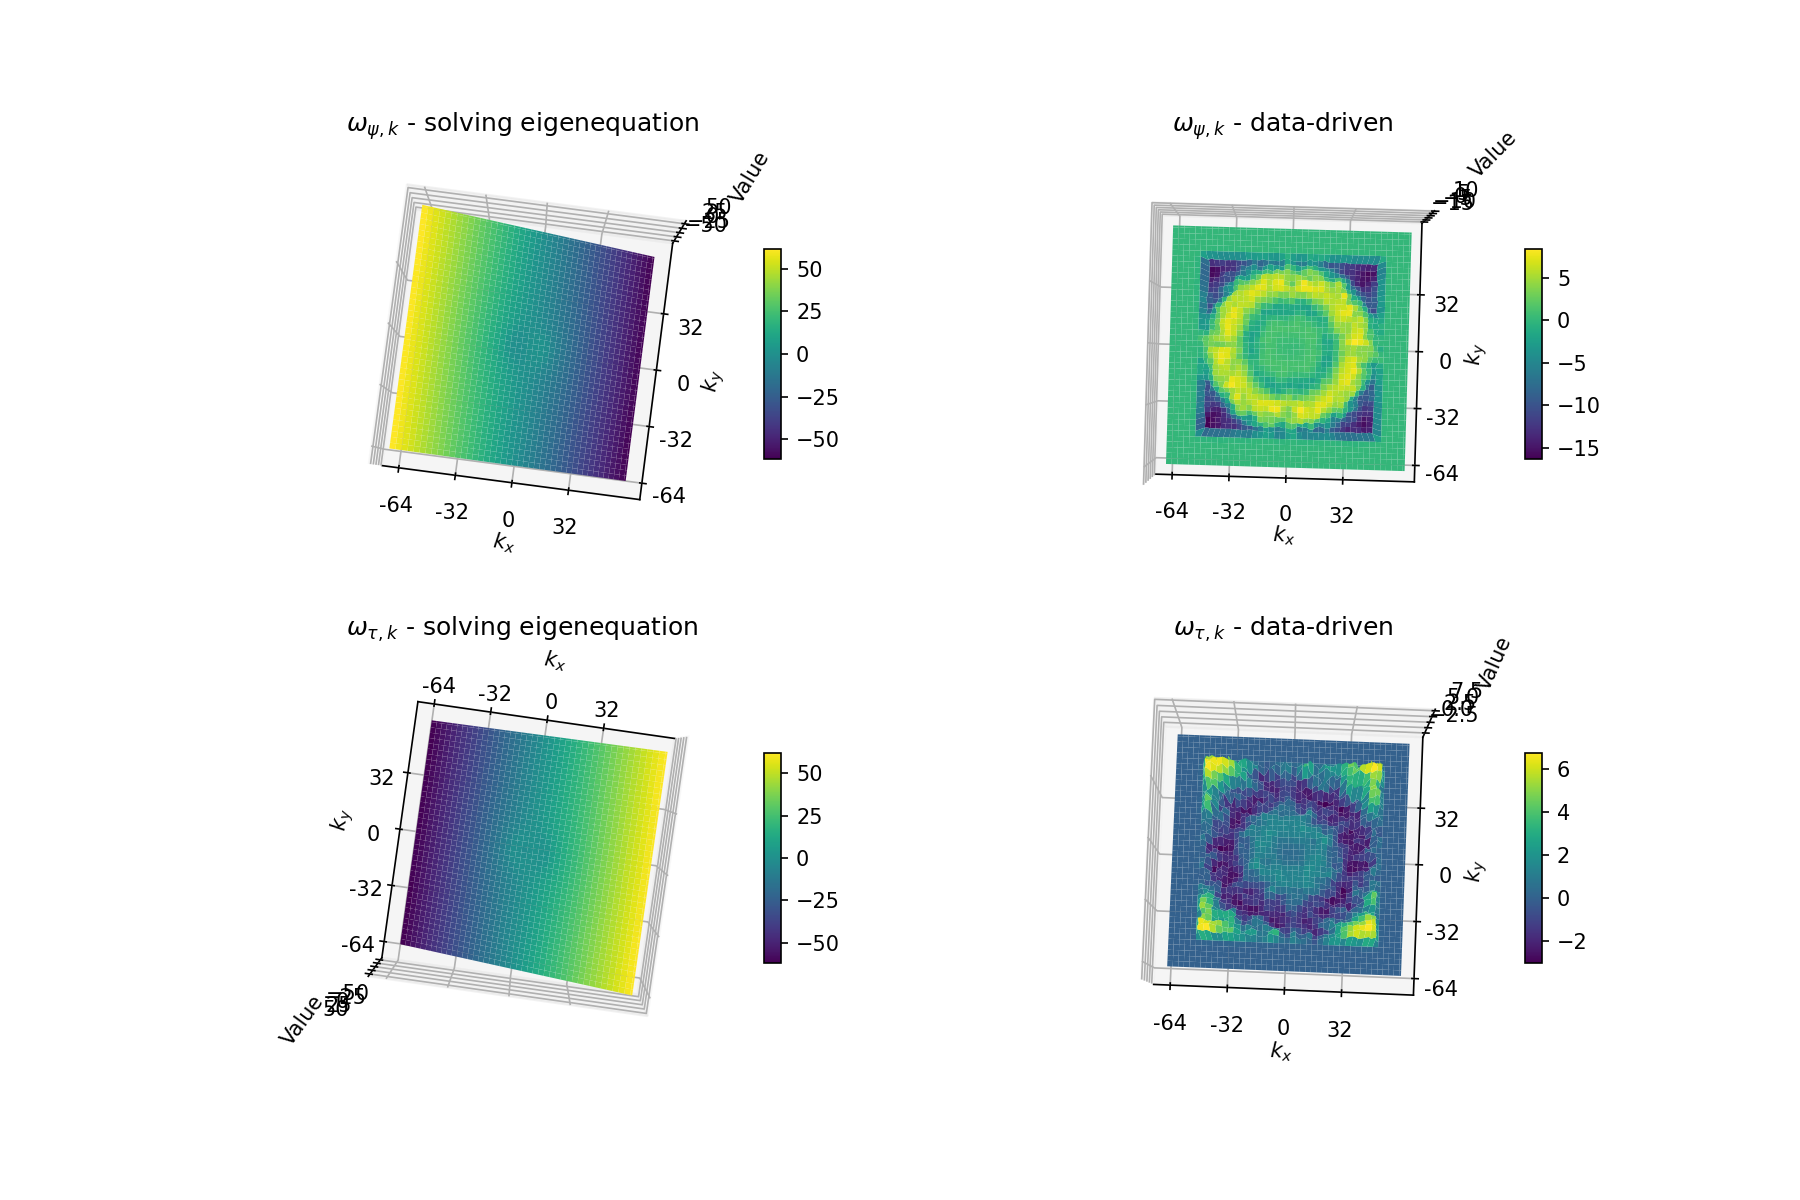

/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_22552/2871425927.py:85: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


In [30]:
# plot omega
from scipy.ndimage import gaussian_filter

%matplotlib notebook

matrix1 = omega1.real
matrix2 = omega[:,:,0]
matrix1 = np.roll(matrix1, shift=K//2, axis=0)
matrix1 = np.roll(matrix1, shift=K//2, axis=1)
matrix2 = np.roll(matrix2, shift=K//2, axis=0) 
matrix2 = np.roll(matrix2, shift=K//2, axis=1)

matrix3 = omega2.real
matrix4 = omega[:,:,1]
matrix3 = np.roll(matrix3, shift=K//2, axis=0)
matrix3 = np.roll(matrix3, shift=K//2, axis=1)
matrix4 = np.roll(matrix4, shift=K//2, axis=0) 
matrix4 = np.roll(matrix4, shift=K//2, axis=1)

# Generate grid indices for the KxK matrices
x = np.linspace(0, K, num=K, endpoint=False) #np.fft.fftfreq(K) * K
y = np.linspace(0, K, num=K, endpoint=False) #np.fft.fftfreq(K) * K
X, Y = np.meshgrid(x, y)
kx = np.roll(np.fft.fftfreq(K) * K, shift=K//2)
ky = np.roll(np.fft.fftfreq(K) * K, shift=K//2)
smoothed_matrix2 = gaussian_filter(matrix2, sigma=1)
smoothed_matrix4 = gaussian_filter(matrix4, sigma=1)

# Create a figure for the plots
fig = plt.figure(figsize=(12, 8))

# Plot for matrix1
ax1 = fig.add_subplot(221, projection='3d')  # 1 row, 2 columns, 1st subplot
surf1 = ax1.contourf(X, Y, matrix1, cmap='seismic')
ax1.set_title(r'$\omega_{\psi,k}$ - solving eigenequation')
ax1.set_xlabel('$k_x$')
ax1.set_ylabel('$k_y$')
ax1.set_zlabel('Value')
ax1.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax1.set_xticklabels(kx[::32].astype(int))
ax1.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax1.set_yticklabels(kx[::32].astype(int))
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=12)

# Plot for matrix2
ax2 = fig.add_subplot(222, projection='3d')  # 1 row, 2 columns, 2nd subplot
surf2 = ax2.contour(X, Y, smoothed_matrix2, cmap='seismic')
ax2.set_title(r'$\omega_{\psi,k}$ - data-driven')
ax2.set_xlabel('$k_x$')
ax2.set_ylabel('$k_y$')
ax2.set_zlabel('Value')
# ax2.set_zlim(-60, 60)
ax2.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax2.set_xticklabels(kx[::32].astype(int))
ax2.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax2.set_yticklabels(kx[::32].astype(int))
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=12)

# Plot for matrix1
ax3 = fig.add_subplot(223, projection='3d')  # 1 row, 2 columns, 1st subplot
surf3 = ax3.contour(X, Y, matrix3, cmap='seismic')
ax3.set_title(r'$\omega_{\tau,k}$ - solving eigenequation')
ax3.set_xlabel('$k_x$')
ax3.set_ylabel('$k_y$')
ax3.set_zlabel('Value')
ax3.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax3.set_xticklabels(kx[::32].astype(int))
ax3.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax3.set_yticklabels(kx[::32].astype(int))
fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=12)

# Plot for matrix2
ax4 = fig.add_subplot(224, projection='3d')  # 1 row, 2 columns, 2nd subplot
surf4 = ax4.contour(X, Y, smoothed_matrix4, cmap='seismic')
ax4.set_title(r'$\omega_{\tau,k}$ - data-driven')
ax4.set_xlabel('$k_x$')
ax4.set_ylabel('$k_y$')
ax4.set_zlabel('Value')
# ax2.set_zlim(-60, 60)
ax4.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax4.set_xticklabels(kx[::32].astype(int))
ax4.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax4.set_yticklabels(kx[::32].astype(int))
fig.colorbar(surf4, ax=ax4, shrink=0.5, aspect=12)

plt.tight_layout()
# plt.savefig('omega_compare.png',dpi=150)
plt.show()